In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

cs224 
last updated: 2020-05-24 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()
# sns.set_style("whitegrid")

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

Data Source: [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19), the data behind the dashboard: [Coronavirus COVID-19 Global Cases by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).

It seems that there are currently [data-changes](https://github.com/CSSEGISandData/COVID-19/commit/0cea9b2179306618bd7917798819ebf6608d67de#comments) in progress that cause issues. This is mostly an issue for the US data, so that I comment it out. The US data as used in this notebook **is currently wrong**.

In [5]:
covid19.time_series_19_covid_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563,3778,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072,7653,8145,8676,9216,9998
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750,766,773,782,789,795,803,820,832,842,850,856,868,872,876,880,898,916,933,946,948,949,964,969,981,989
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182,5369,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201,7377,7542,7728,7918,8113
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743,743,745,745,747,748,750,751,751,752,752,754,755,755,758,760,761,761,761,761,761,761,762,762,762,762
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27,27,27,30,35,35,35,36,36,36,43,43,45,45,45,45,48,48,48,48,50,52,52,58,60,61


In [6]:
covid19.time_series_19_covid_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,5,5,10,10,10,15,18,18,29,32,32,32,32,32,40,43,54,99,112,131,135,150,166,179,188,188,207,220,228,252,260,310,331,345,397,421,458,468,472,502,558,558,610,648,691,745,745,778,801,850,930,938,996,1040
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,10,17,17,31,31,33,44,52,67,76,89,99,104,116,131,154,165,182,197,217,232,248,251,277,283,302,314,327,345,356,385,394,403,410,422,431,455,470,488,519,531,543,570,595,605,620,627,650,654,682,688,694,705,714,715,727,742,758,771,777,783
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,12,12,12,12,12,32,32,32,65,65,24,65,29,29,31,31,37,46,61,61,62,90,90,90,113,237,347,405,460,591,601,691,708,783,846,894,1047,1099,1152,1204,1355,1408,1479,1508,1558,1651,1702,1779,1821,1872,1936,1998,2067,2197,2323,2467,2546,2678,2841,2998,3058,3158,3271,3409,3507,3625,3746,3968,4062,4256,4426
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,10,10,10,10,16,21,26,31,39,52,58,71,71,128,128,128,169,169,191,205,235,248,282,309,333,344,344,344,385,398,423,468,468,472,493,499,514,521,526,537,545,550,550,568,576,596,604,615,617,624,628,639,639,652,653
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,2,2,2,2,4,4,4,5,5,5,5,6,6,6,6,6,6,6,6,6,6,6,7,7,11,11,11,11,11,11,11,11,13,13,13,13,14,14,17,17,17,17,17,17,17,17,18


In [7]:
df = covid19.get_cases_by_region(region='China')
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-19,84063,79310,4638,0,0,0
2020-05-20,84063,79310,4638,0,0,0
2020-05-21,84063,79310,4638,0,0,0
2020-05-22,84081,79332,4638,18,22,0
2020-05-23,84084,79335,4638,3,3,0


* [BAR CHART ANNOTATIONS WITH PANDAS AND MATPLOTLIB](https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html)

In [8]:
df = covid19.get_rki_df()
cbr_germany = covid19.CasesByRegion('Germany', df=df)
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-19,176956,160281,8081,468,0,77
2020-05-20,177548,160281,8143,592,0,62
2020-05-21,177854,160281,8201,306,0,58
2020-05-22,178128,160280,8228,274,-1,27
2020-05-23,178258,160278,8259,130,-2,31


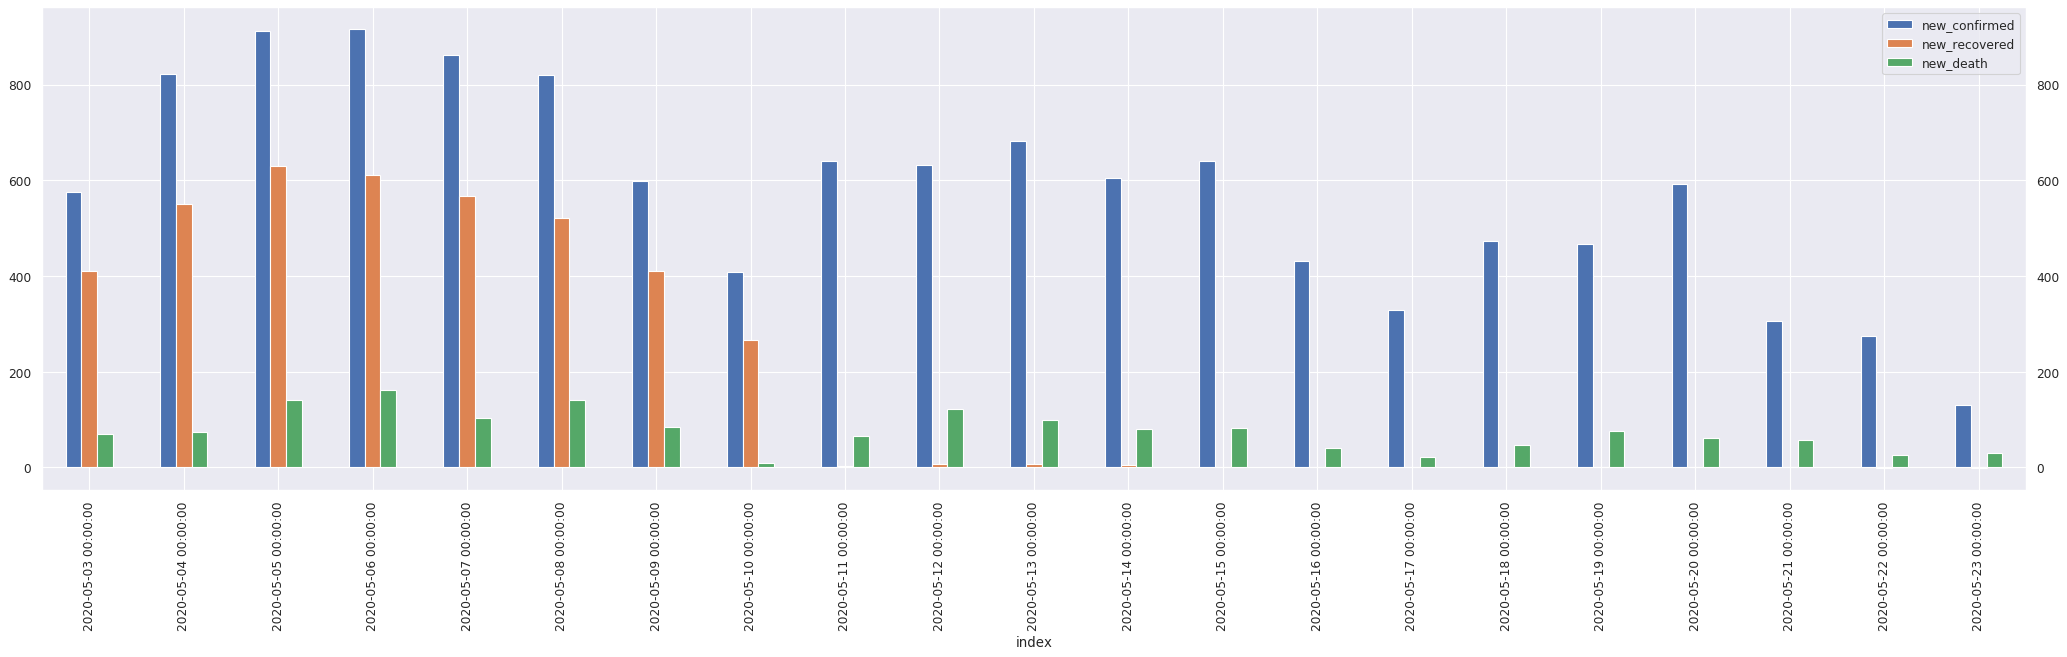

In [9]:
cbr_germany.plot_daily_stats()

[COVID-19-Pandemie#Deutschland](https://de.wikipedia.org/wiki/COVID-19-Pandemie#Deutschland):

> Am 22. März 2020 einigten sich Bund und Länder auf ein „umfassendes Kontaktverbot“, statt weitergehende Ausgangssperren zu beschließen.


> Roughly 2020-04-21 the taken actions show clear effect; roughly 4.5 weeks later.

| prediction date | predicted day for reaching 100 threshold | predicted max | growth rate  | steady state rate  |
| :--- | :--- | ---: | ---: | ---: |
| 2020-04-02 | 2020-04-21 |  92845 | 0.057 | - |
| 2020-04-03 | 2020-04-23 |  99774 | 0.054 | - |
| 2020-04-04 | 2020-04-25 | 107193 | 0.051 | - |
| 2020-04-05 | 2020-04-27 | 114511 | 0.049 | - |
| 2020-04-06 | 2020-04-29 | 119618 | 0.045 | - |
| 2020-04-07 | 2020-04-29 | 121354 | 0.039 | - |
| 2020-04-08 | 2020-04-30 | 123011 | 0.035 | - |
| 2020-04-09 | 2020-04-30 | 125833 | 0.031 | - |
| 2020-04-10 | - | - | 0.049 | 4820 |
| 2020-04-11 | - | - | 0.042 | 4739 |
| 2020-04-12 | - | - | 0.040 | 4570 |
| 2020-04-13 | - | - | 0.036 | 4300 |
| 2020-04-14 | - | - | 0.033 | 3927 |
| 2020-04-15 | - | - | 0.029 | 3451 |
| 2020-04-16 | - | - | 0.026 | 3086 |
| 2020-04-17 | - | - | 0.024 | 2845 |
| 2020-04-19 | - | - | 0.021 | 2666 |
| 2020-04-20 | - | - | 0.020 | 2554 |
| 2020-04-21 | - | - | 0.018 | 2356 |
| 2020-04-24 | - | - | 0.015 | 2043 |
| 2020-04-25 | 2020-05-24 | 166654 | 0.011 | - |
| 2020-04-26 | 2020-05-26 | 167739 | 0.010 | - |
| 2020-04-27 | 2020-05-26 | 168771 | 0.009 | - |
| 2020-04-28 | - | - | 0.013 | 1538 |
| 2020-04-29 | 2020-05-25 | 169856 | 0.008 | - |
| 2020-04-30 | 2020-05-26 | 170081 | 0.007 | - |
| 2020-05-01 | 2020-06-06 | 176154 | 0.007 | - |
| 2020-05-02 | 2020-06-06 | 176278 | 0.006 | - |
| 2020-05-03 | 2020-06-06 | 176466 | 0.006 | - |
| 2020-05-04 | 2020-06-06 | 176419 | 0.005 | - |
| 2020-05-09 | 2020-06-07 | 177511 | 0.004 | - |
| 2020-05-11 | 2020-06-07 | 177421 | 0.003 | - |
| 2020-05-12 | 2020-06-07 | 177954 | 0.003 | - |
| 2020-05-17 | 2020-06-08 | 179372 | 0.002 | - |
| 2020-05-24 | 2020-06-09 | 180945 | 0.002 | - |

In [10]:
cbr_germany.fit(first_date=pd.to_datetime('2020-03-09'))

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


In [11]:
# cbr_germany.fit_df0.loc[pd.to_datetime('2020-05-24')]

sigmoid+asymmetric: seor: 409.57309375737526, max asymptotic: 180945.18655999587; growth-rate: 0.002, date:2020-06-09 00:00:00, projected value: 91.00123091145544


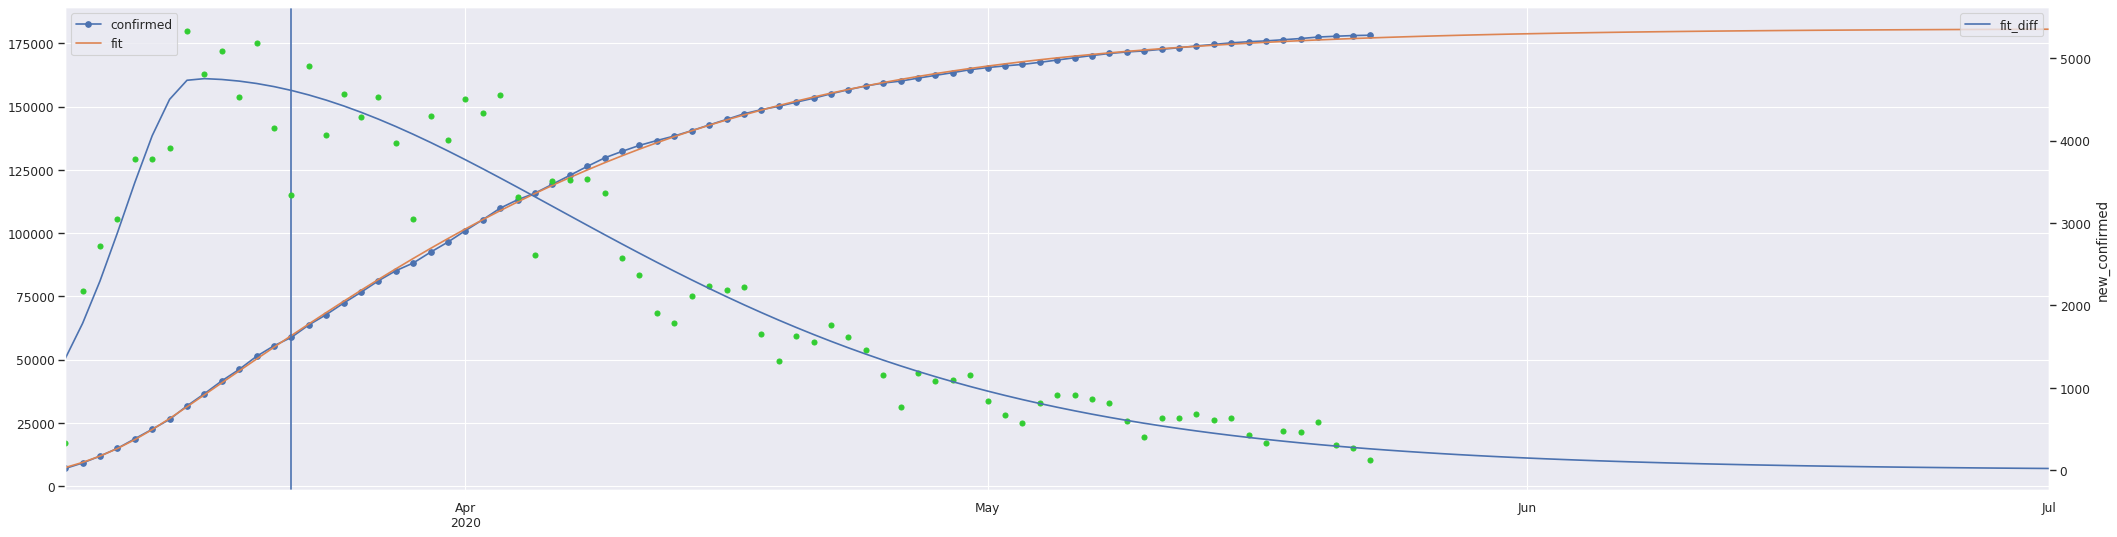

In [12]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [13]:
cbr_germany.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,4751.629148


In [14]:
cbr_germany.calculate_R_estimates()
cbr_germany.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-21,0.589,0.684,0.504,0.607,0.627


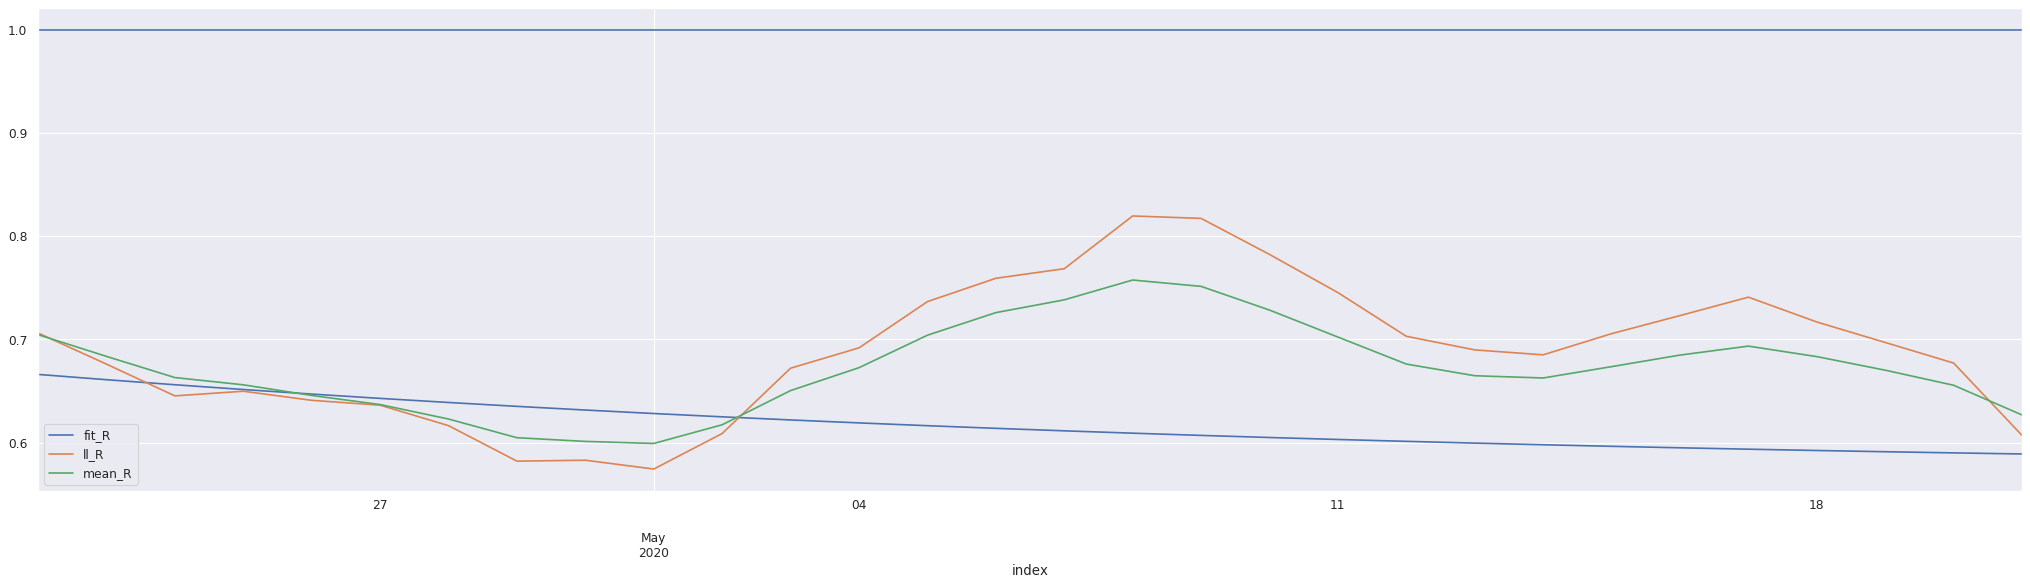

In [15]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [16]:
df = covid19.get_austria_df()
cbr_austria = covid19.CasesByRegion('Austria', df=df)
cbr_austria.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-19,16288,14678,599,49,64,0
2020-05-20,16321,14882,601,33,204,2
2020-05-21,16372,14951,601,51,69,0
2020-05-22,16406,15005,605,34,54,4
2020-05-23,16453,15037,606,47,32,1


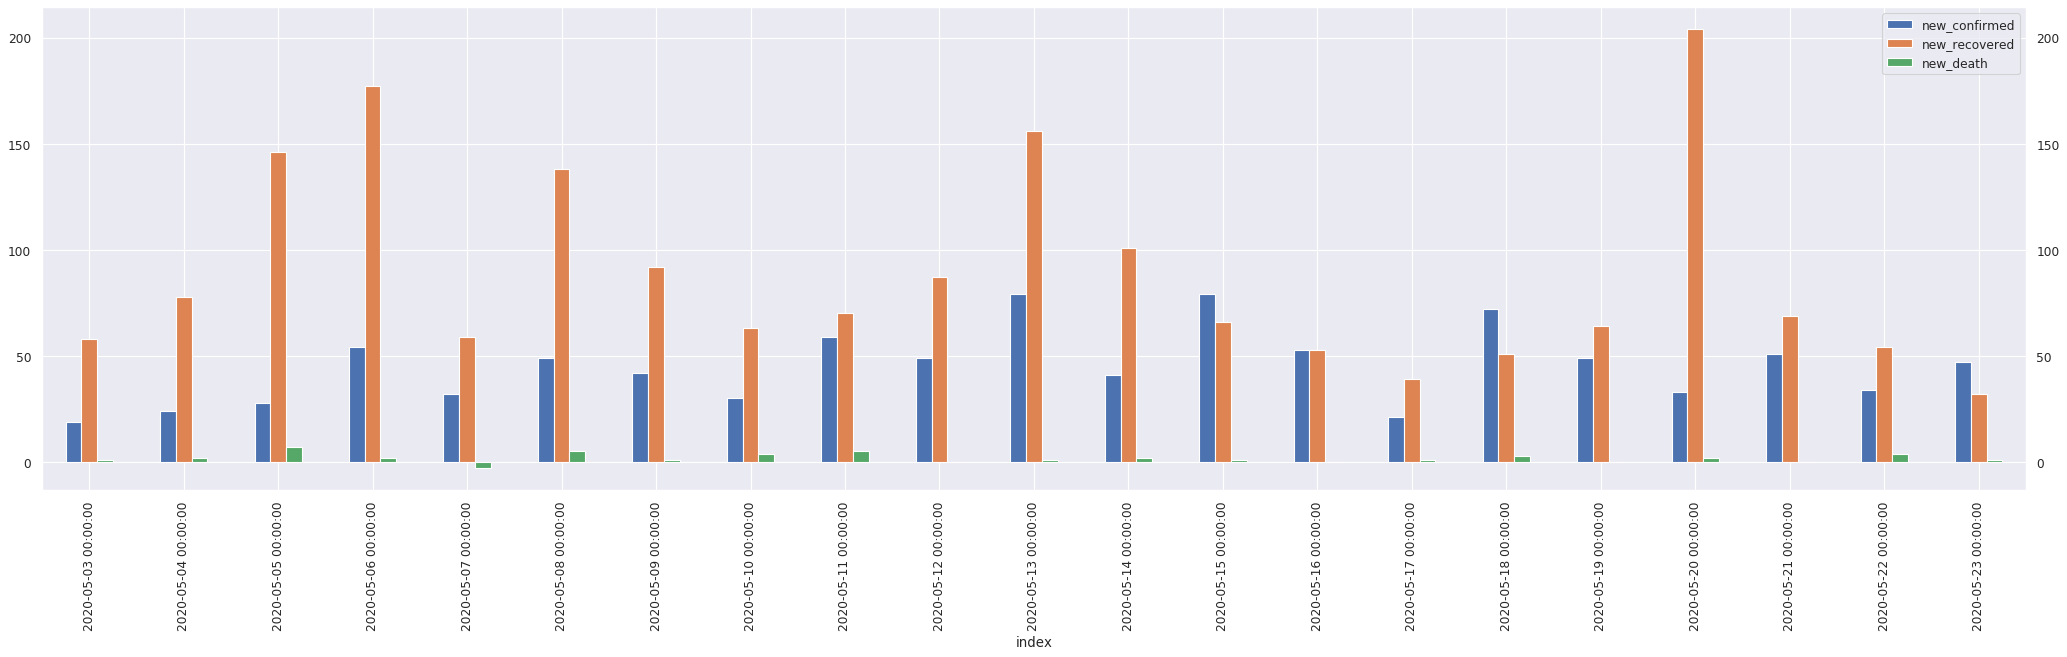

In [17]:
cbr_austria.plot_daily_stats()

[COVID-19-Pandemie#%C3%96sterreich](https://de.wikipedia.org/wiki/COVID-19-Pandemie#%C3%96sterreich)

> Nachdem Mitte März zuerst einzelne Gemeinden unter Quarantäne gestellt wurden, verlautbarte Bundeskanzler Sebastian Kurz am 15. März eine landesweite Ausgangsbeschränkung, verbunden mit einer Einschränkung der Versammlungsfreiheit auf bis zu fünf Personen.

`2020-03-15`

| prediction date | predicted day for reaching 100 threshold | predicted max | growth rate | steady state rate  |
| :--- | :--- | ---: | ---: | ---: |
| 2020-04-02 | 2020-04-12 | 13859 | 0.042 | - |
| 2020-04-03 | 2020-04-12 | 13864 | 0.036 | - |
| 2020-04-04 | 2020-04-12 | 14082 | 0.030 | - |
| 2020-04-05 | 2020-04-12 | 13978 | 0.025 | - |
| 2020-04-06 | 2020-04-11 | 13947 | 0.020 | - |
| 2020-04-07 | 2020-04-12 | 14033 | 0.017 | - |
| 2020-04-08 | 2020-04-12 | 14121 | 0.014 | - |
| 2020-04-09 | 2020-04-12 | 14229 | 0.012 | - |
| 2020-04-10 | 2020-04-12 | 14350 | 0.010 | - |
| 2020-04-11 | 2020-04-13 | 14488 | 0.009 | - |
| 2020-04-12 | - | - | 0.012 | 106 |
| 2020-04-13 | - | - | 0.012 | 123 |
| 2020-04-14 | - | - | 0.011 | 126 |
| 2020-04-15 | - | - | 0.010 | 114 |
| 2020-04-15 | - | - | 0.009 | 107 |
| 2020-04-17 | - | - | 0.009 | 106 |
| 2020-04-19 | - | - | 0.007 |  95 |
| 2020-04-20 | - | - | 0.007 |  87 |
| 2020-04-21 | - | - | 0.006 |  83 |
| 2020-04-24 | - | - | 0.005 |  68 |
| 2020-04-26 | 2020-05-01 | 15208 | 0.002 |  - |
| 2020-04-27 | 2020-05-01 | 15096 | 0.002 |  - |
| 2020-04-28 | 2020-05-01 | 15129 | 0.002 |  - |
| 2020-04-29 | - | - | 0.005 |  84 |
| 2020-04-30 | - | - | 0.005 |  81 |
| 2020-05-01 | - | - | 0.005 |  77 |
| 2020-05-02 | - | - | 0.005 |  76 |
| 2020-05-02 | - | - | 0.004 |  75 |
| 2020-05-04 | - | - | 0.004 |  73 |
| 2020-05-09 | - | - | 0.003 |  60 |
| 2020-05-11 | - | - | 0.003 |  58 |
| 2020-05-12 | - | - | 0.003 |  57 |
| 2020-05-17 | - | - | 0.003 |  55 |
| 2020-05-24 | - | - | 0.003 |  54 |

In [18]:
einwohner_deutschland = 83019213.0
einwohner_bayern      = 13076721.0
prozent_bayern        = einwohner_bayern / einwohner_deutschland
einwohner_österreich  =  8793370.0
prozent_österreich    = einwohner_österreich / einwohner_deutschland

austria_new_confirmed_threshold = (100.0 * prozent_österreich) // 1 + 1
austria_new_confirmed_threshold

11.0

In [19]:
cbr_austria.fit(first_date=pd.to_datetime('2020-03-09'), new_confirmed_threshold=austria_new_confirmed_threshold)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 73.1614548609503; growth-rate: 0.003, date:2020-07-01 00:00:00, projected value: 54.371899846408475


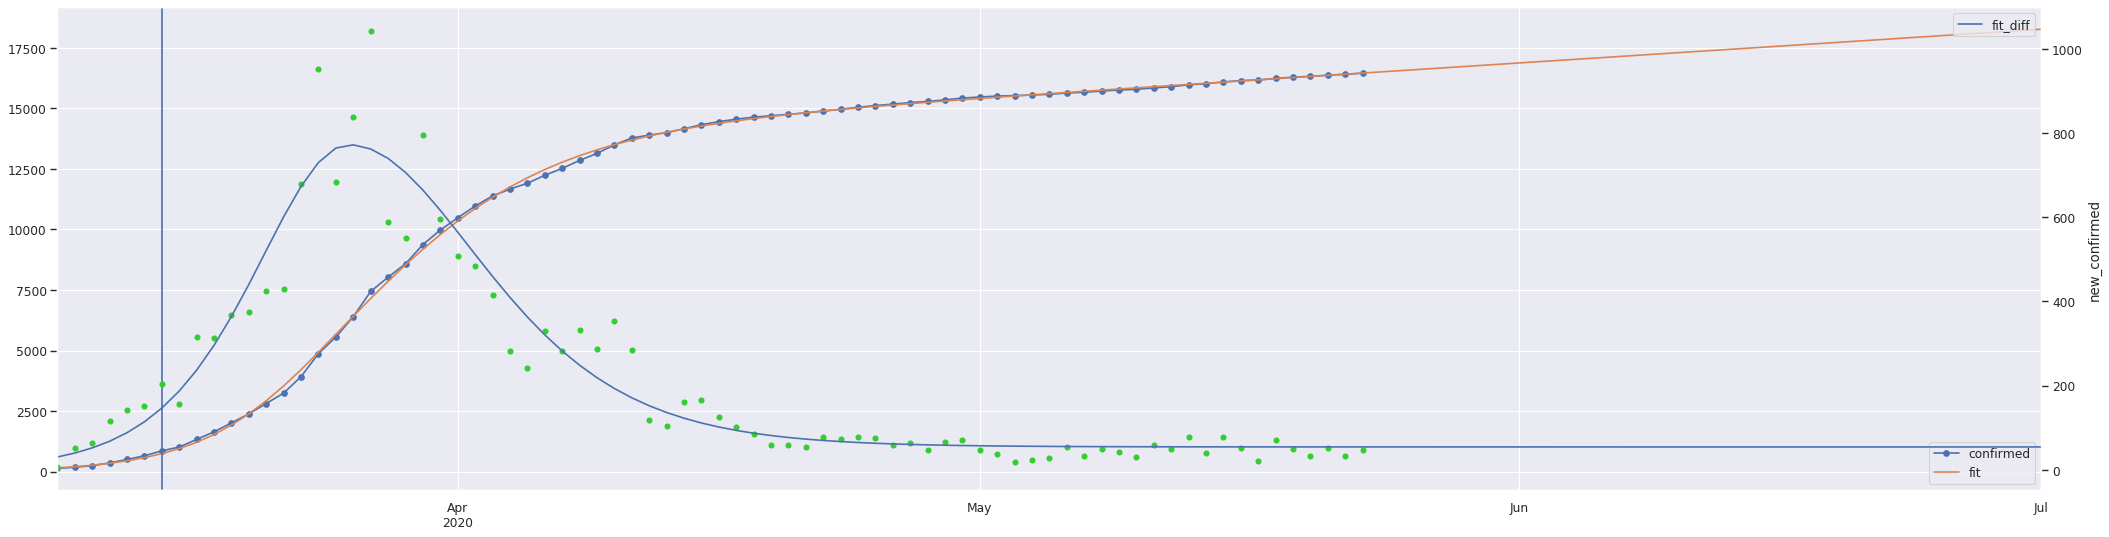

In [20]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_austria.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 15))

In [21]:
cbr_austria.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,772.071521


In [22]:
cbr_austria.calculate_R_estimates()
cbr_austria.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-21,0.997,0.773,0.993,0.915,0.895


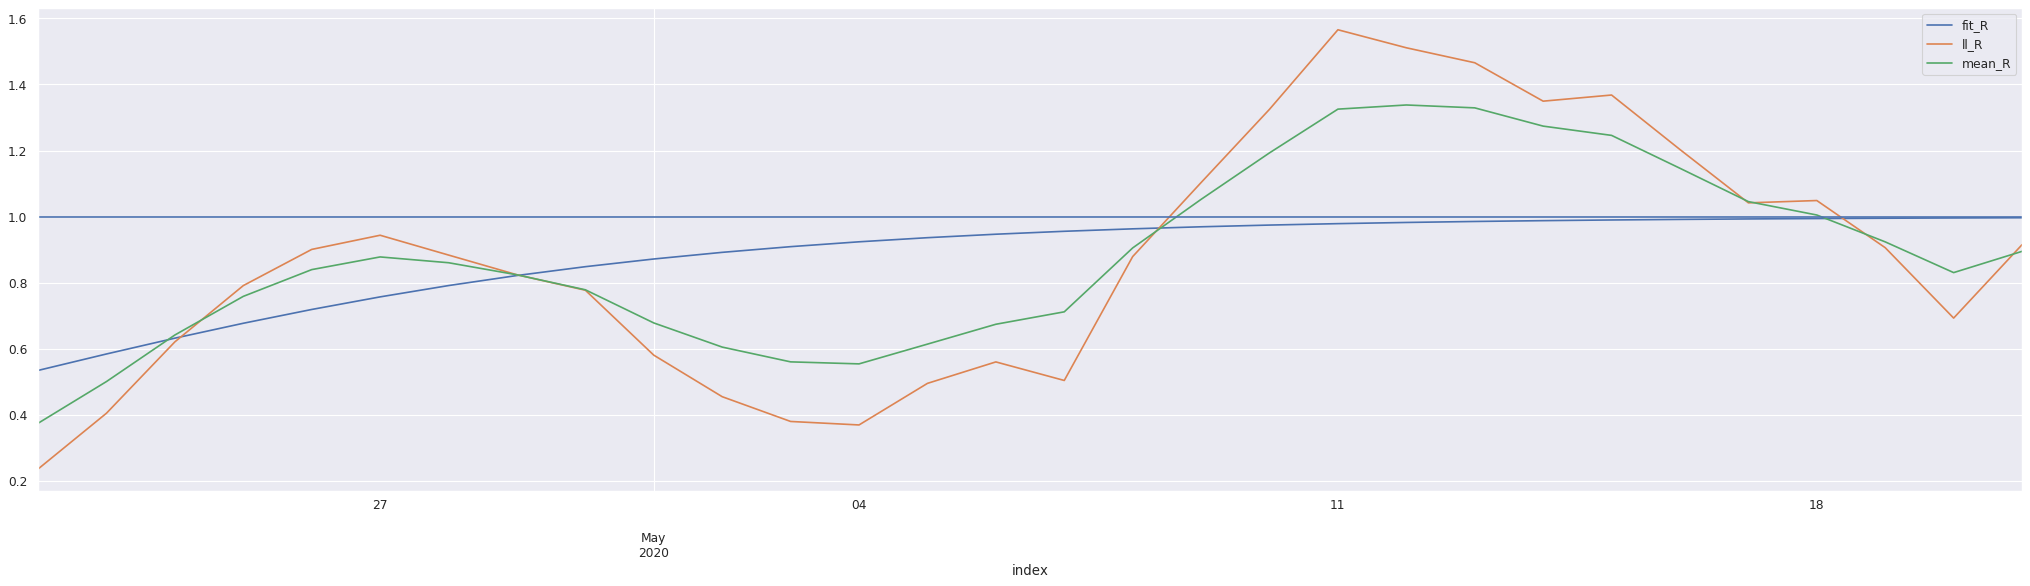

In [23]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_austria.plot_R(ax=ax) # , plot_start_date='2020-03-10'

[COVID-19-Pandemie#Dänemark](https://de.wikipedia.org/wiki/COVID-19-Pandemie#D%C3%A4nemark)

> Dänemark hat besonders früh mit strikten Maßnahmen auf die Corona-Krise reagiert, unter anderem sind seit dem 14. März die Grenzen für Ausländer ohne triftigen Einreisegrund geschlossen.

`2020-03-14`

In [24]:
cbr_denmark = covid19.CasesByRegion('Denmark')
cbr_denmark.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-19,11242,9614,551,76,115,3
2020-05-20,11315,9734,554,73,120,3
2020-05-21,11380,9841,561,65,107,7
2020-05-22,11428,9962,561,48,121,0
2020-05-23,11487,10034,561,59,72,0


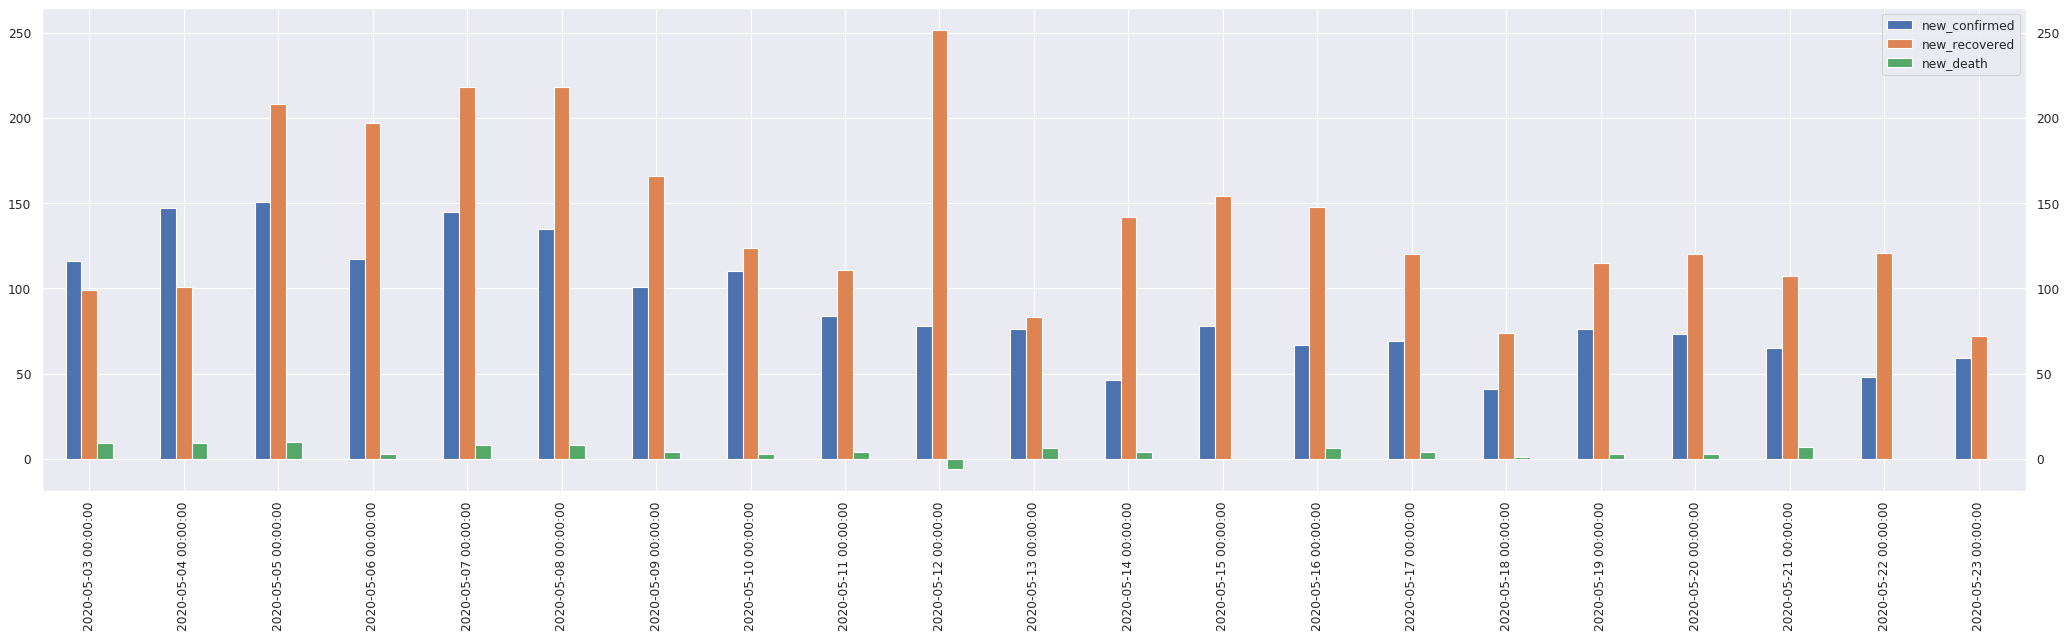

In [25]:
cbr_denmark.plot_daily_stats()

8.0


 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+linear: seor: 40.94864892110428, max asymptotic: 7180.634976595461; growth-rate: 0.008, date:2020-07-01 00:00:00, projected value: 105.06178416269151


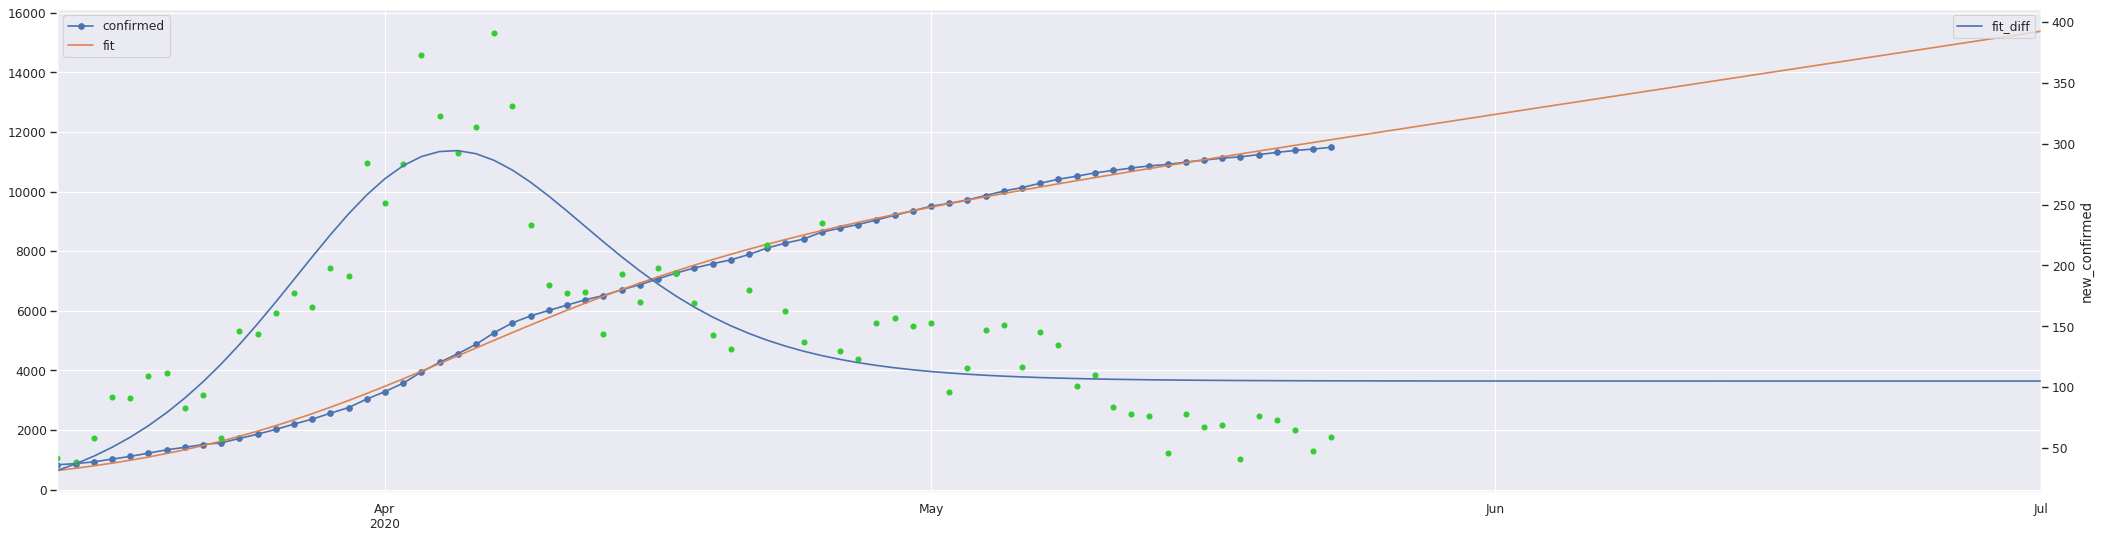

In [26]:
population_denmark  =  5822763.0
percent_denmark     = population_denmark / einwohner_deutschland

denmark_new_confirmed_threshold = (100.0 * percent_denmark) // 1 + 1
print(denmark_new_confirmed_threshold)

# first_date=pd.to_datetime('2020-03-09')
# first_date=pd.to_datetime('2020-03-14')
cbr_denmark.fit(first_date=pd.to_datetime('2020-03-14'), new_confirmed_threshold=denmark_new_confirmed_threshold)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_denmark.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 14))

In [27]:
cbr_denmark.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,294.283725


In [28]:
cbr_denmark.calculate_R_estimates()
cbr_denmark.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-05-21,0.994,1.011,1.228,0.857,0.954


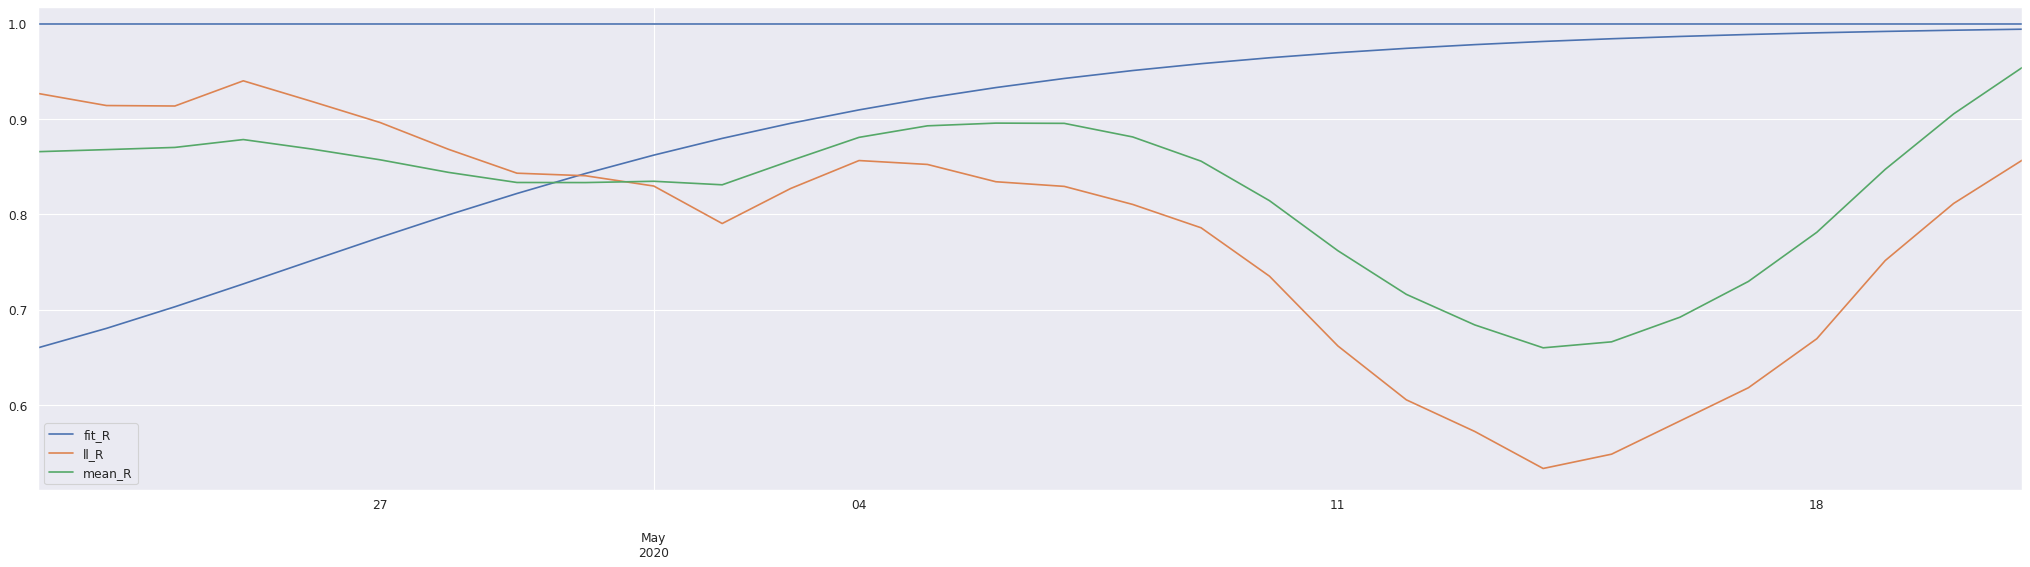

In [29]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_denmark.plot_R(ax=ax) # , plot_start_date='2020-03-10'

There are several data issues since 2020-03-12/2020-03-13 in the input data as pointed out here: [Italy has the same number of cases today as they did yesterday.](https://github.com/CSSEGISandData/COVID-19/issues/599)

Also trying to get the raw numbers that [Coronavirus-Monitor](https://interaktiv.morgenpost.de/corona-virus-karte-infektionen-deutschland-weltweit/?fbclid=IwAR04HlqzakGaNssQzbz4d8o8R3gz0C910U8tvfYlBT6P0lVJJvHfk9uS2rc) is using for Germany from [@datentaeterin](https://twitter.com/datentaeterin/status/1237807179815686144). These numbers seem to be more up-to-date than all the other data-sources.

In [30]:
df = covid19.get_italy_df()
cbr_italy = covid19.CasesByRegion('Italy', df=df)
cbr_italy.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
data,,,,,,
2020-05-19,226699,129401,32169,813,2075,162
2020-05-20,227364,132282,32330,665,2881,161
2020-05-21,228006,134560,32486,642,2278,156
2020-05-22,228658,136720,32616,652,2160,130
2020-05-23,229327,138840,32735,669,2120,119


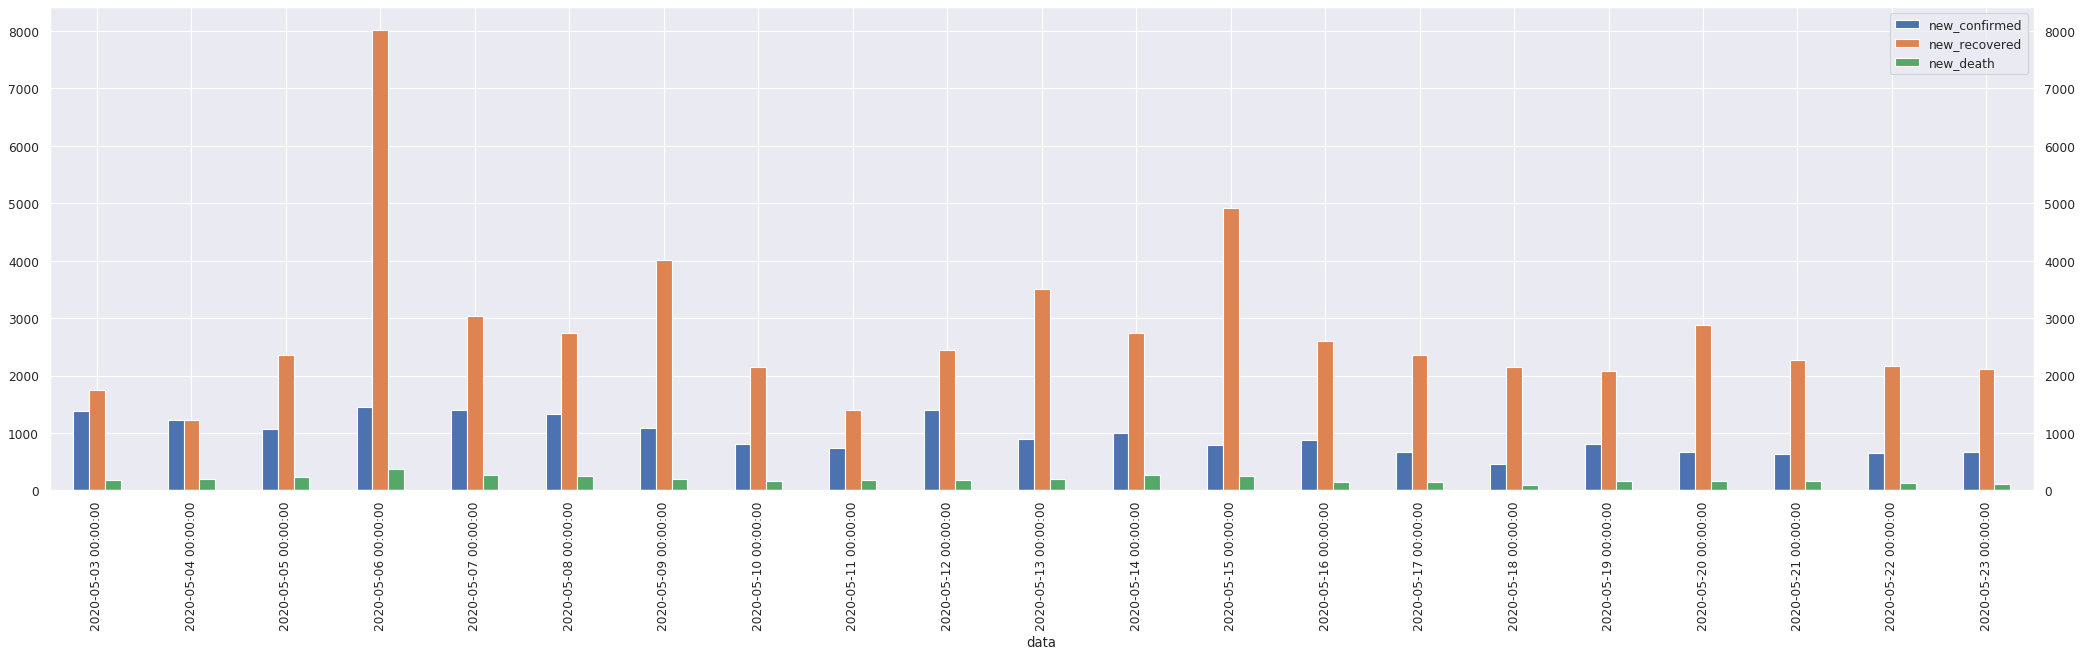

In [31]:
cbr_italy.plot_daily_stats()

In [32]:
cbr_italy.fit(first_date=pd.to_datetime('2020-02-21'))

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:Covariance of the parameters could not be estimated


sigmoid+asymmetric: seor: 443.2646968097911, max asymptotic: 240369.48228282612; growth-rate: 0.003, date:2020-06-24 00:00:00, projected value: 92.35964659170983


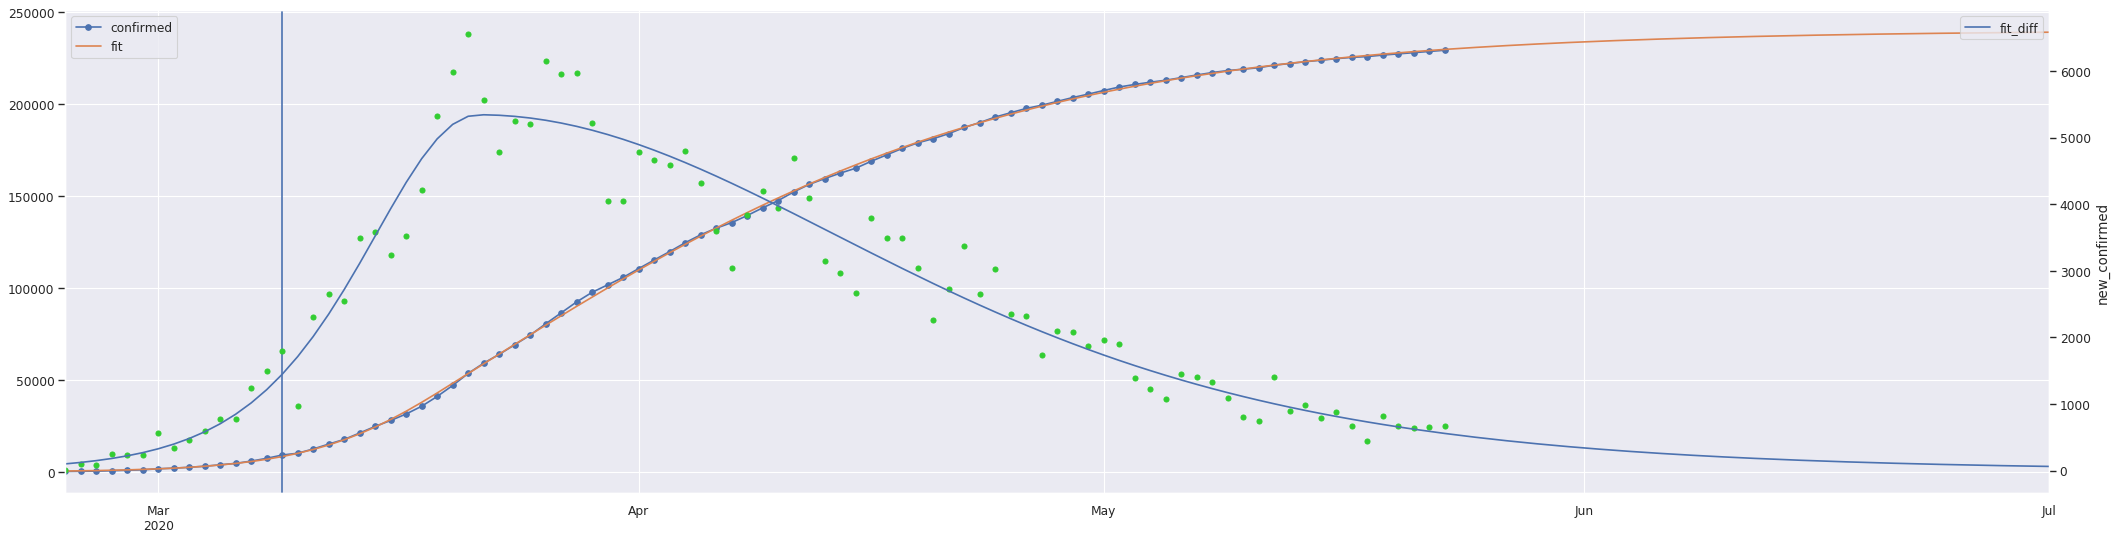

In [33]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_italy.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 9))

In [34]:
cbr_italy.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,5343.833366


In [35]:
cbr_italy.calculate_R_estimates()
cbr_italy.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
data,,,,,
2020-05-21,0.636,0.646,0.556,0.585,0.623


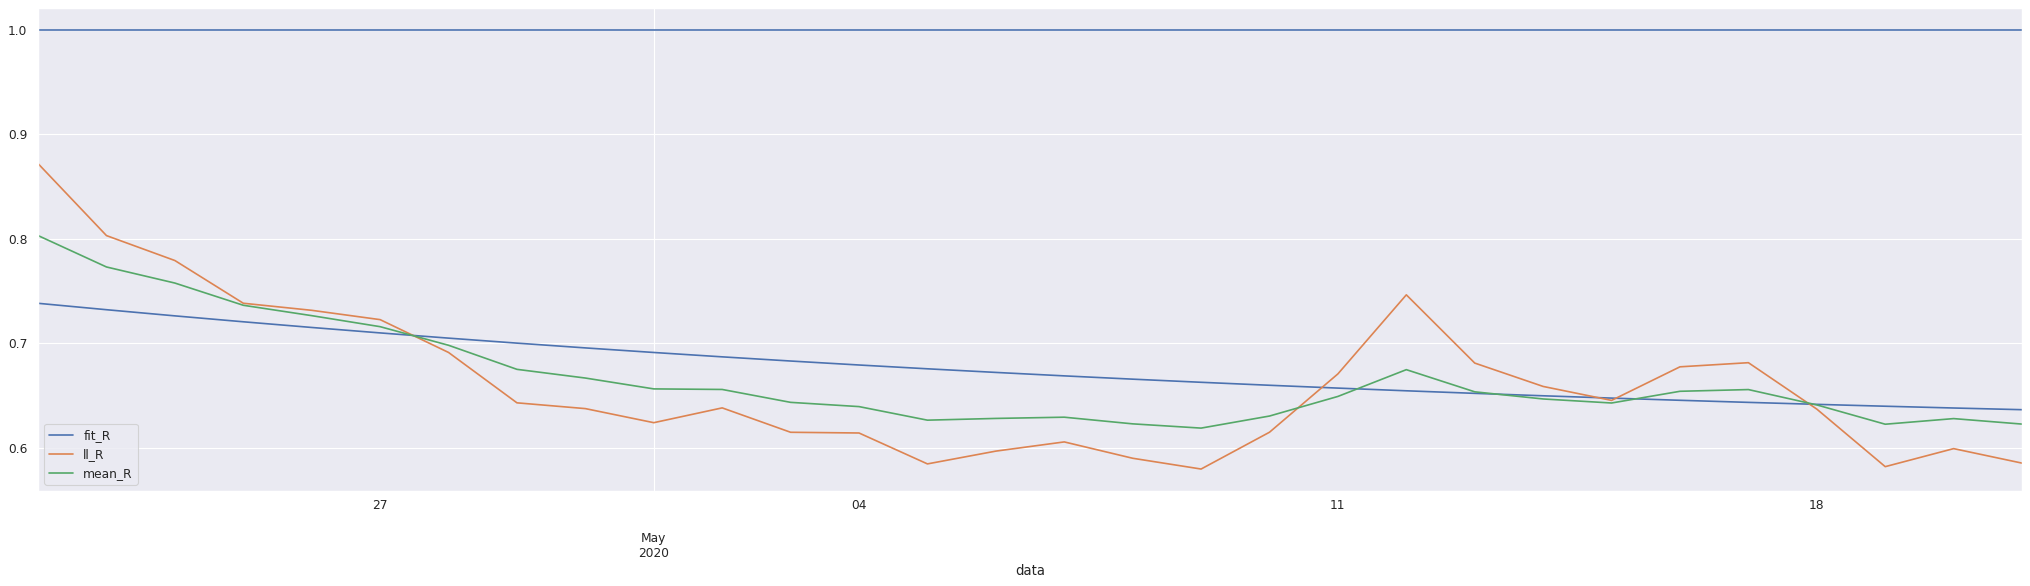

In [36]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_italy.plot_R(ax=ax) # , plot_start_date='2020-03-10'

* [Community Wiki: Resources on Data Science (and friends) vs. COVID-19](https://discourse.data-against-covid.org/t/community-wiki-resources-on-data-science-and-friends-vs-covid-19/731)
* [Number of deaths per age group per country?](https://discourse.data-against-covid.org/t/number-of-deaths-per-age-group-per-country/940)


* [mscbs.gob.es](https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/situacionActual.htm)
* https://covid19.isciii.es/
* [github/datadista](https://github.com/datadista/datasets/tree/master/COVID%2019)

In [37]:
df = covid19.get_spain_df()
cbr_spain = covid19.CasesByRegion('Spain', df=df)
cbr_spain.tail()

read csv


,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-19,232246,150376,27793,280,0,100
2020-05-20,232693,150376,27892,447,0,99
2020-05-21,233037,150376,27940,344,0,48
2020-05-22,234824,150376,28628,1787,0,688
2020-05-23,235290,150376,28678,466,0,50


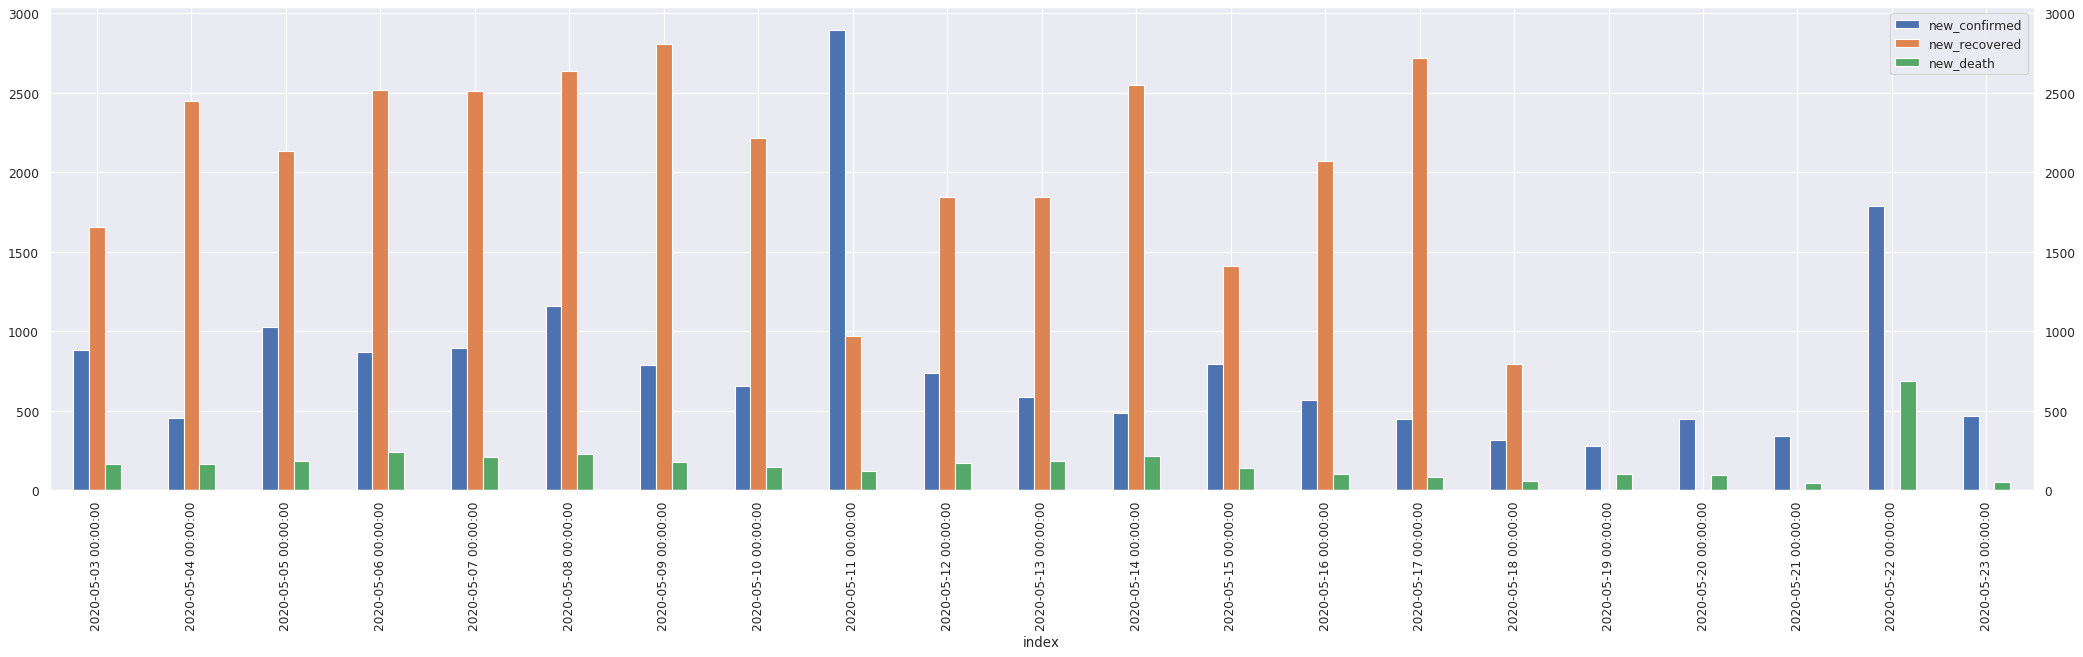

In [38]:
cbr_spain.plot_daily_stats()

In [39]:
cbr_spain.fit(first_date=pd.to_datetime('2020-03-04'))

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 793.7352281550382; growth-rate: 0.003, date:2020-07-01 00:00:00, projected value: 619.0155604314358


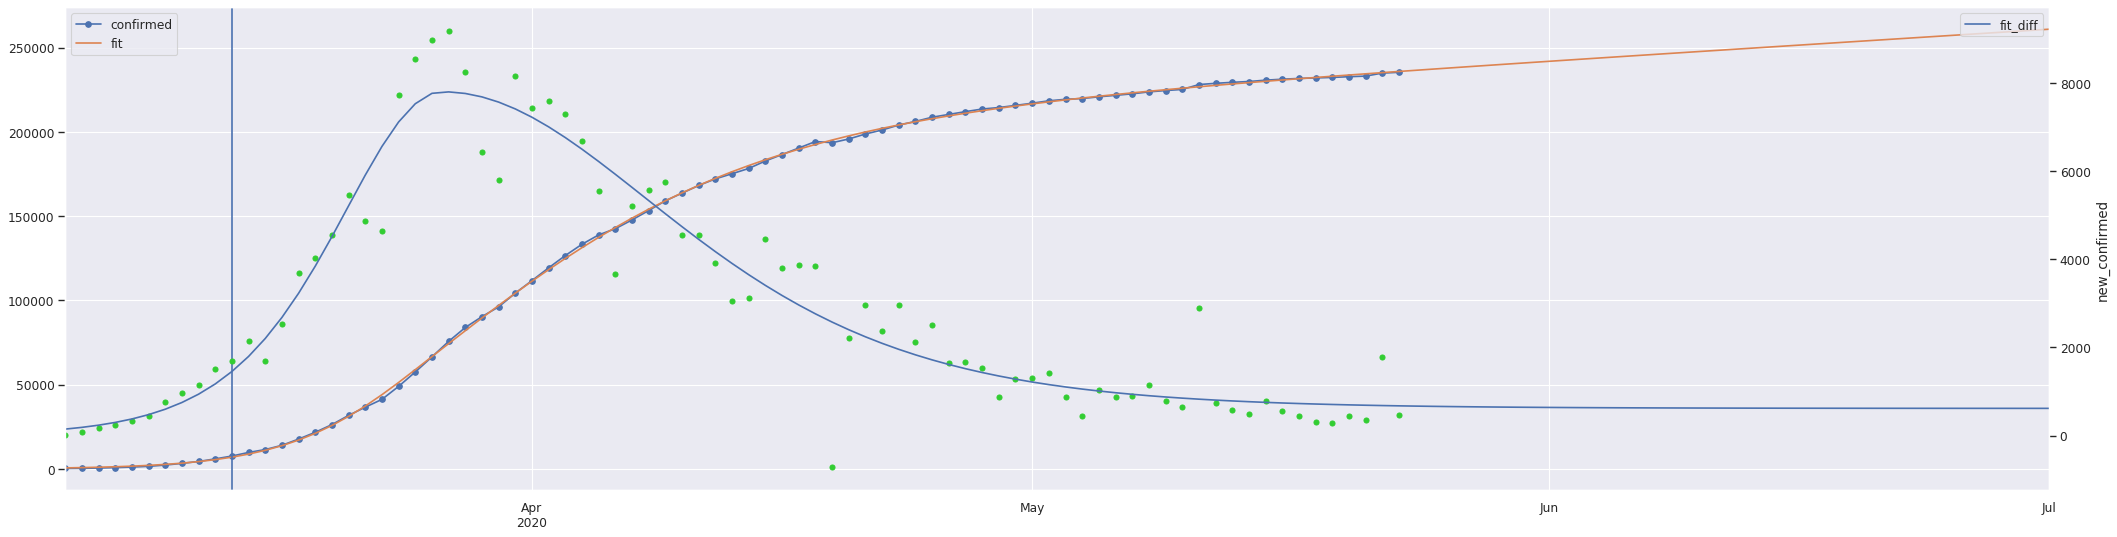

In [40]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_spain.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 14))

In [41]:
cbr_spain.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,7794.644157


In [42]:
cbr_spain.calculate_R_estimates()
cbr_spain.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-21,0.89,0.214,0.722,0.374,0.493


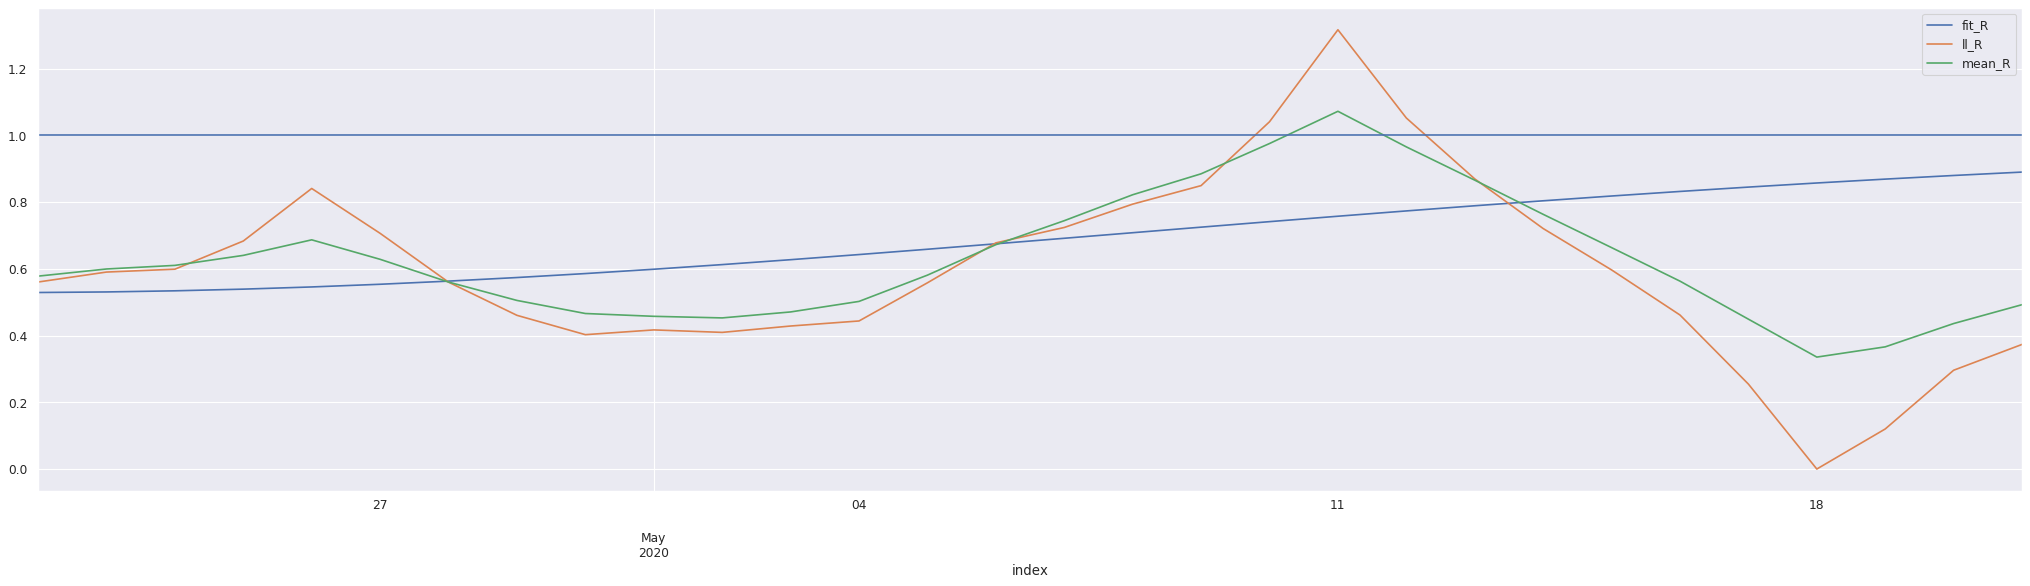

In [43]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_spain.plot_R(ax=ax) # , plot_start_date='2020-03-10'

* [Community Wiki: Resources on Data Science (and friends) vs. COVID-19](https://discourse.data-against-covid.org/t/community-wiki-resources-on-data-science-and-friends-vs-covid-19/731)
* [Number of deaths per age group per country?](https://discourse.data-against-covid.org/t/number-of-deaths-per-age-group-per-country/940)



* [opencovid19-fr / data](https://github.com/opencovid19-fr/data/blob/master/README.en.md)
    * [chiffres-cles.csv](https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv)
    * [dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/5e09dff7cb434fb194e22261689e2887)
    * [santepubliquefrance](https://www.santepubliquefrance.fr/maladies-et-traumatismes/maladies-et-infections-respiratoires/infection-a-coronavirus/articles/infection-au-nouveau-coronavirus-sars-cov-2-covid-19-france-et-monde)

In [44]:
df =covid19.get_france_df()
cbr_france = covid19.CasesByRegion('France', df=df)
cbr_france.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
date,,,,,,
2020-05-19,143427,62563,28022,524,835,-217
2020-05-20,143845,63354,28132,418,791,110
2020-05-21,144163,63858,28215,318,504,83
2020-05-22,144556,64209,0,393,351,0
2020-05-23,144806,64547,0,250,338,0


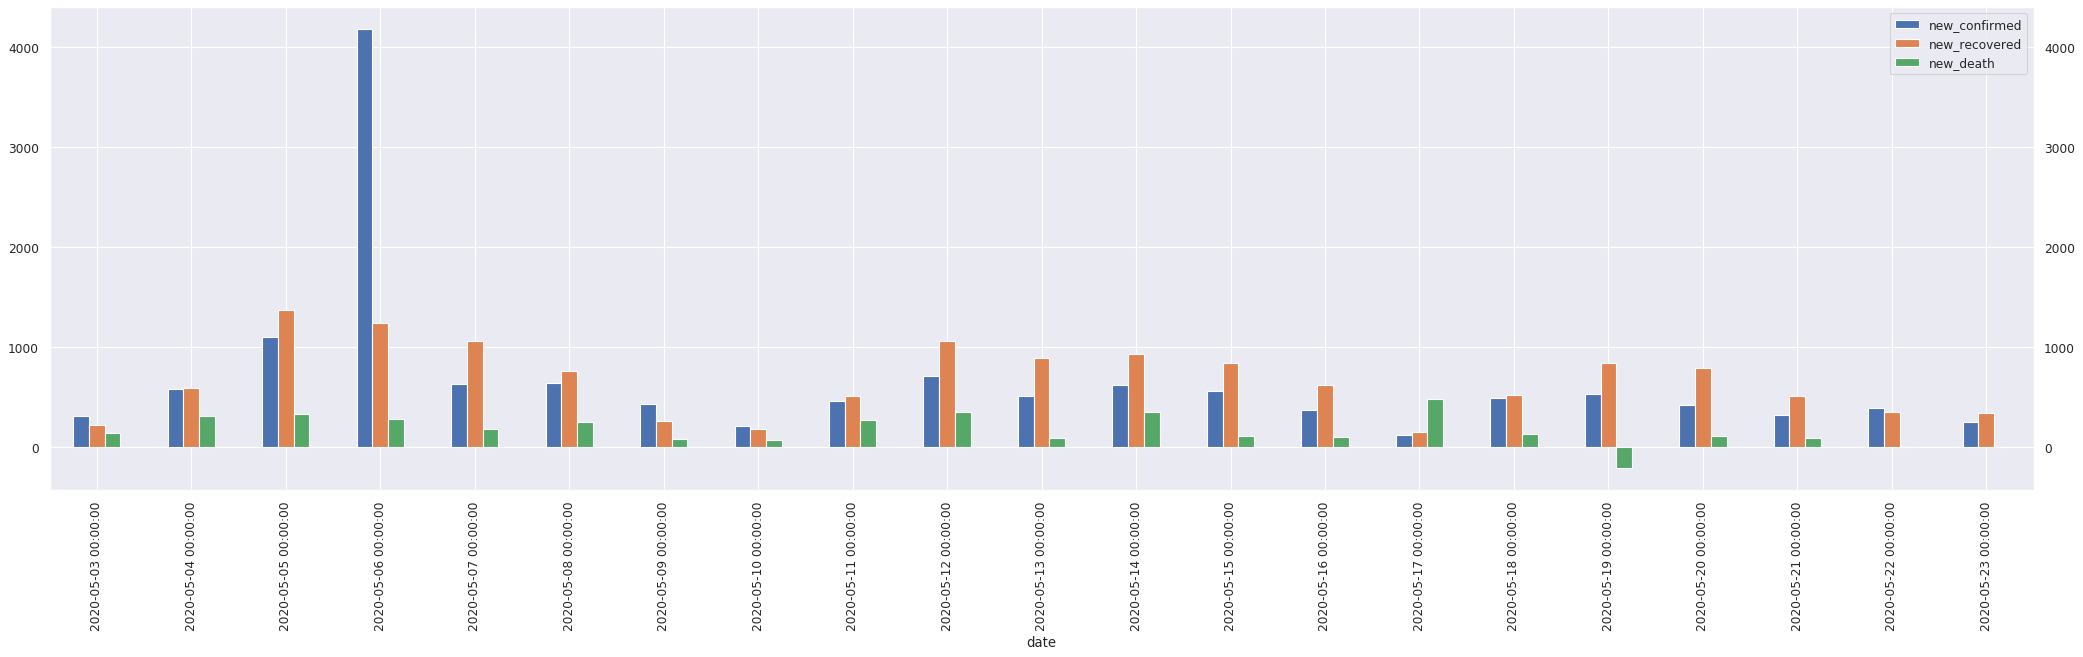

In [45]:
cbr_france.plot_daily_stats()

In [46]:
cbr_france.fit(first_date=pd.to_datetime('2020-03-04'))

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 1000.6651375240656; growth-rate: 0.004, date:2020-07-01 00:00:00, projected value: 418.26943919369523


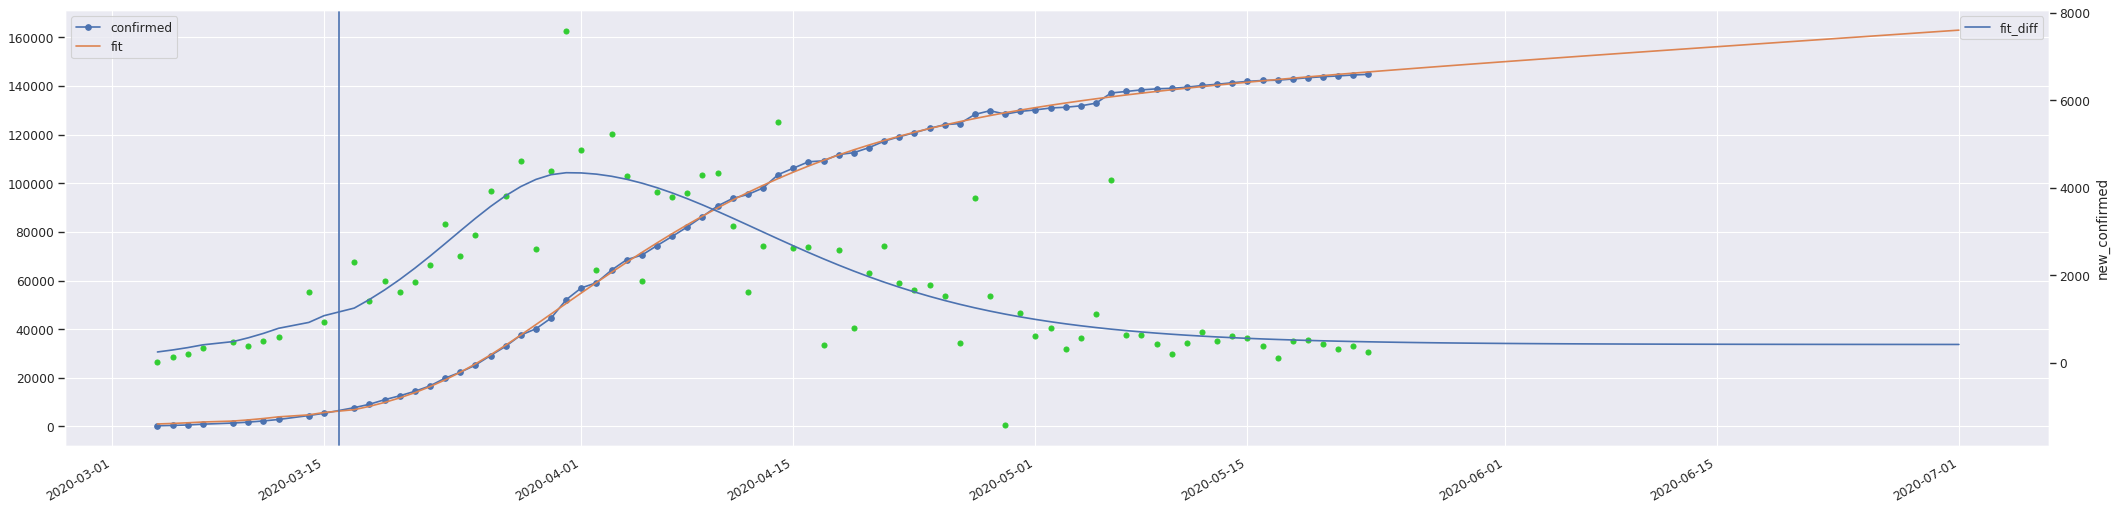

In [47]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_france.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 16))

In [48]:
cbr_france.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,4343.06939


In [49]:
cbr_france.calculate_R_estimates()
cbr_france.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
date,,,,,
2020-05-21,0.85,0.795,0.527,0.6,0.748


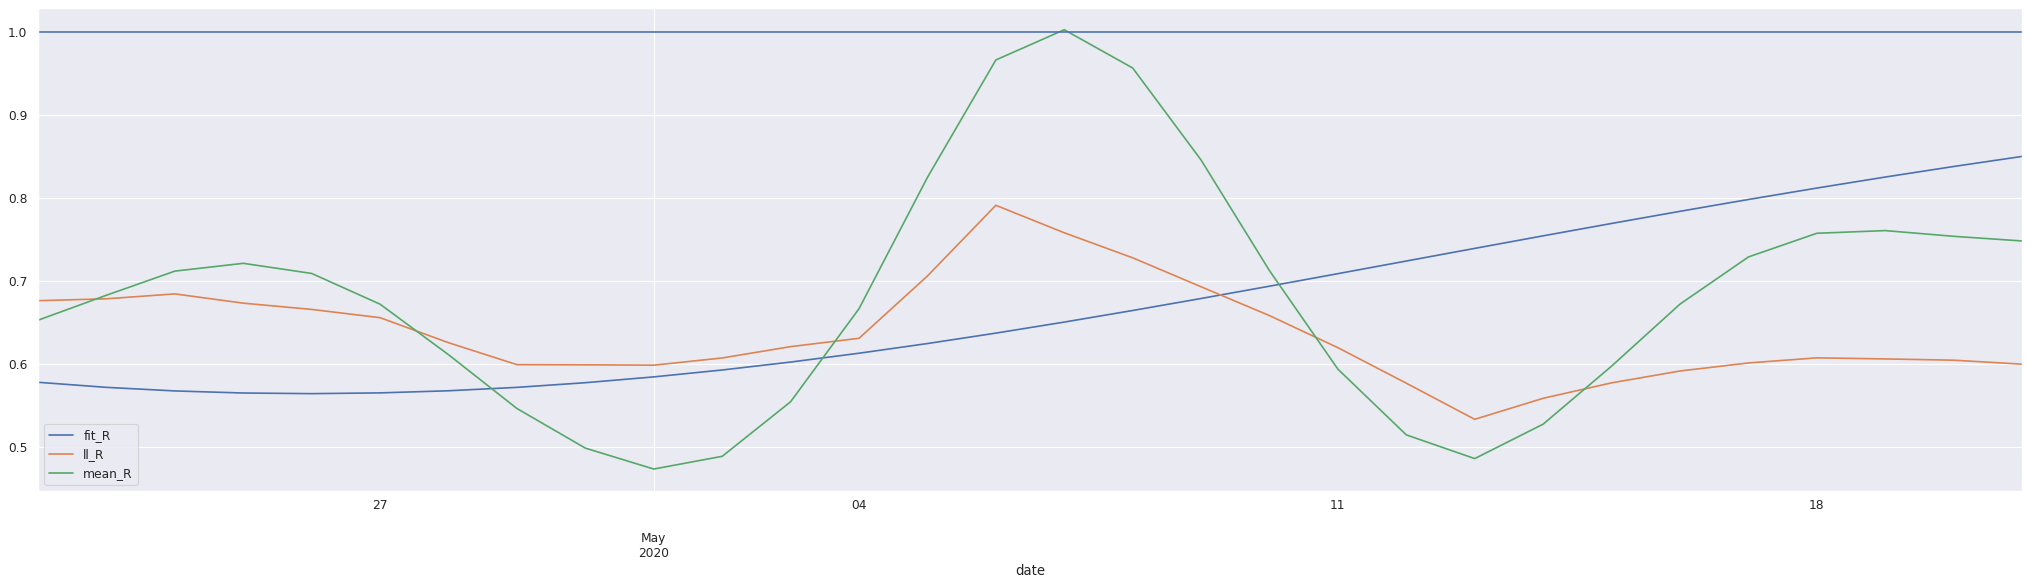

In [50]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_france.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [51]:
cbr_south_korea = covid19.CasesByRegion('Korea, South')
cbr_south_korea.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-19,11110,10066,263,32,128,0
2020-05-20,11122,10135,264,12,69,1
2020-05-21,11142,10162,264,20,27,0
2020-05-22,11165,10194,266,23,32,2
2020-05-23,11190,10213,266,25,19,0


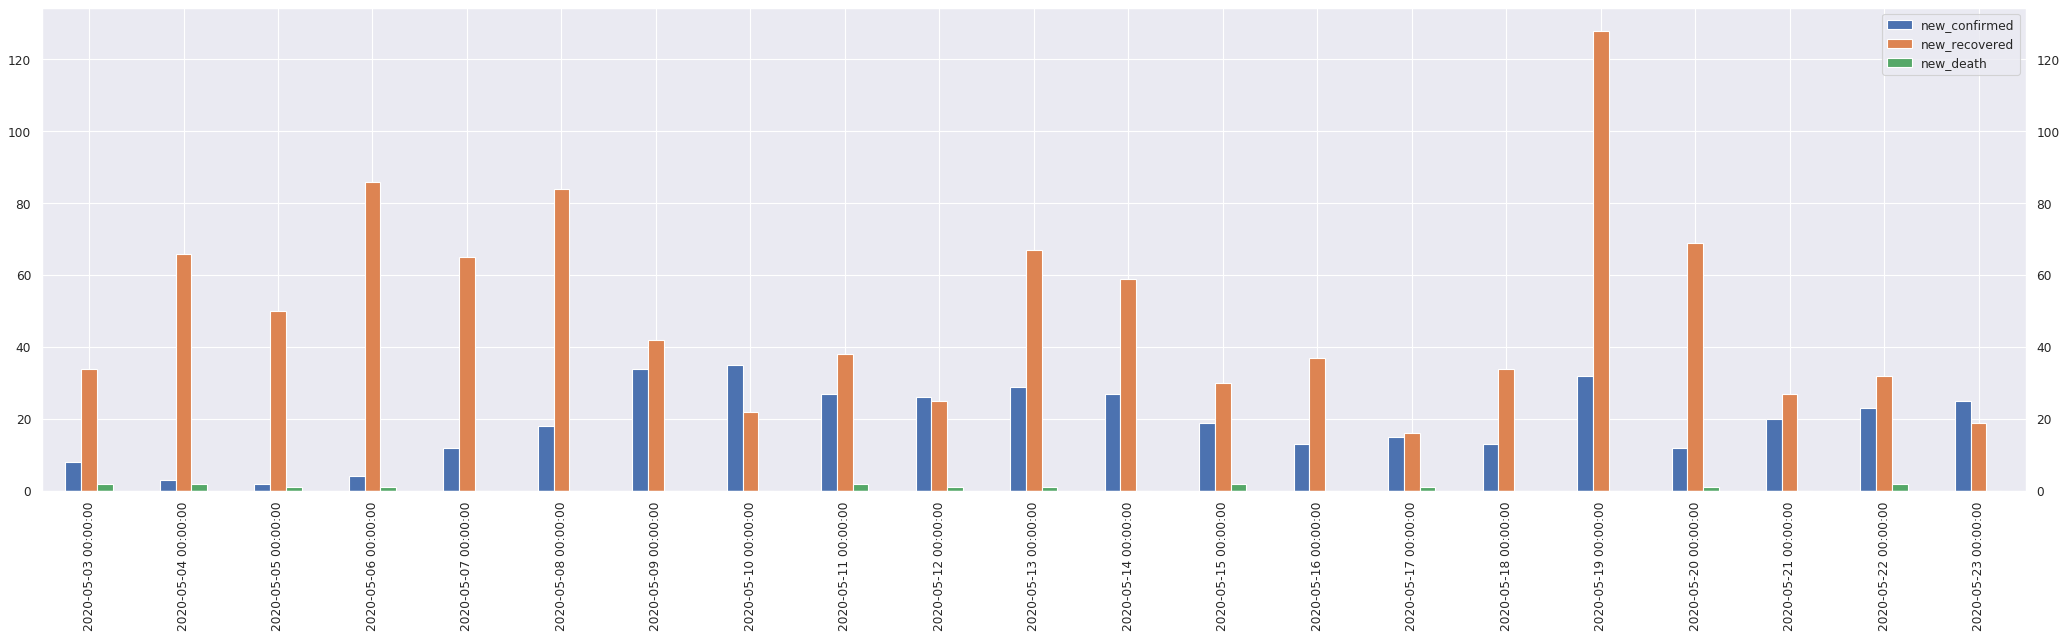

In [52]:
cbr_south_korea.plot_daily_stats()

In [53]:
cbr_uk = covid19.CasesByRegion('United Kingdom')
cbr_uk.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-19,250138,1099,35422,2429,9,546
2020-05-20,249619,1116,35786,-519,17,364
2020-05-21,252246,1134,36124,2627,18,338
2020-05-22,255544,1142,36475,3298,8,351
2020-05-23,258504,1149,36757,2960,7,282


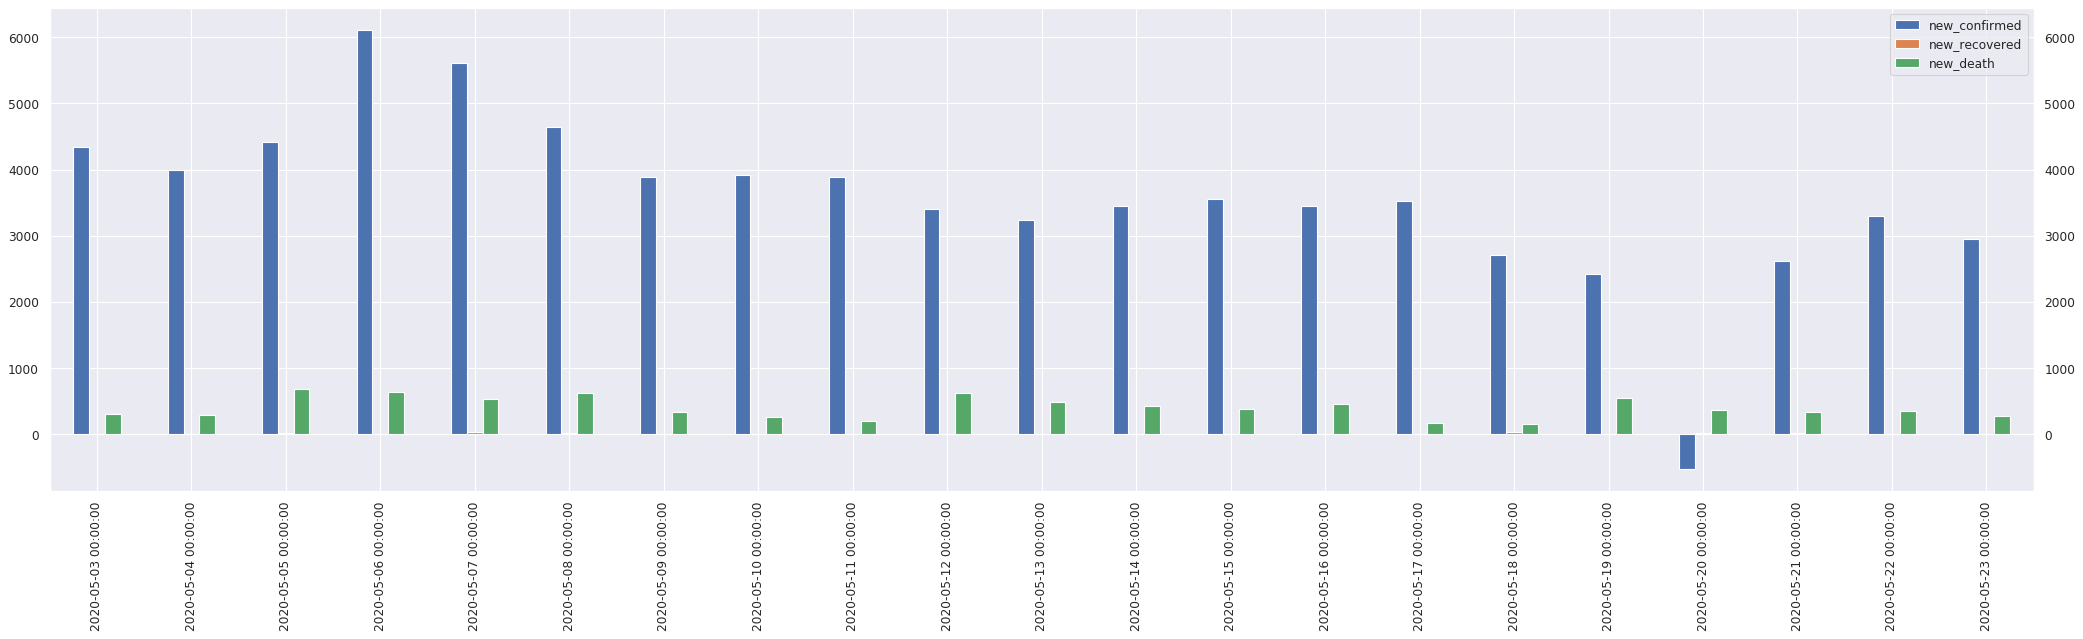

In [54]:
cbr_uk.plot_daily_stats()

In [55]:
cbr_uk.fit(first_date=pd.to_datetime('2020-03-05'))

sigmoid+asymmetric: seor: 826.9486813248622, max asymptotic: 374141.7980637262; growth-rate: 0.013, date:2020-07-01 00:00:00, projected value: 628.7221980117231


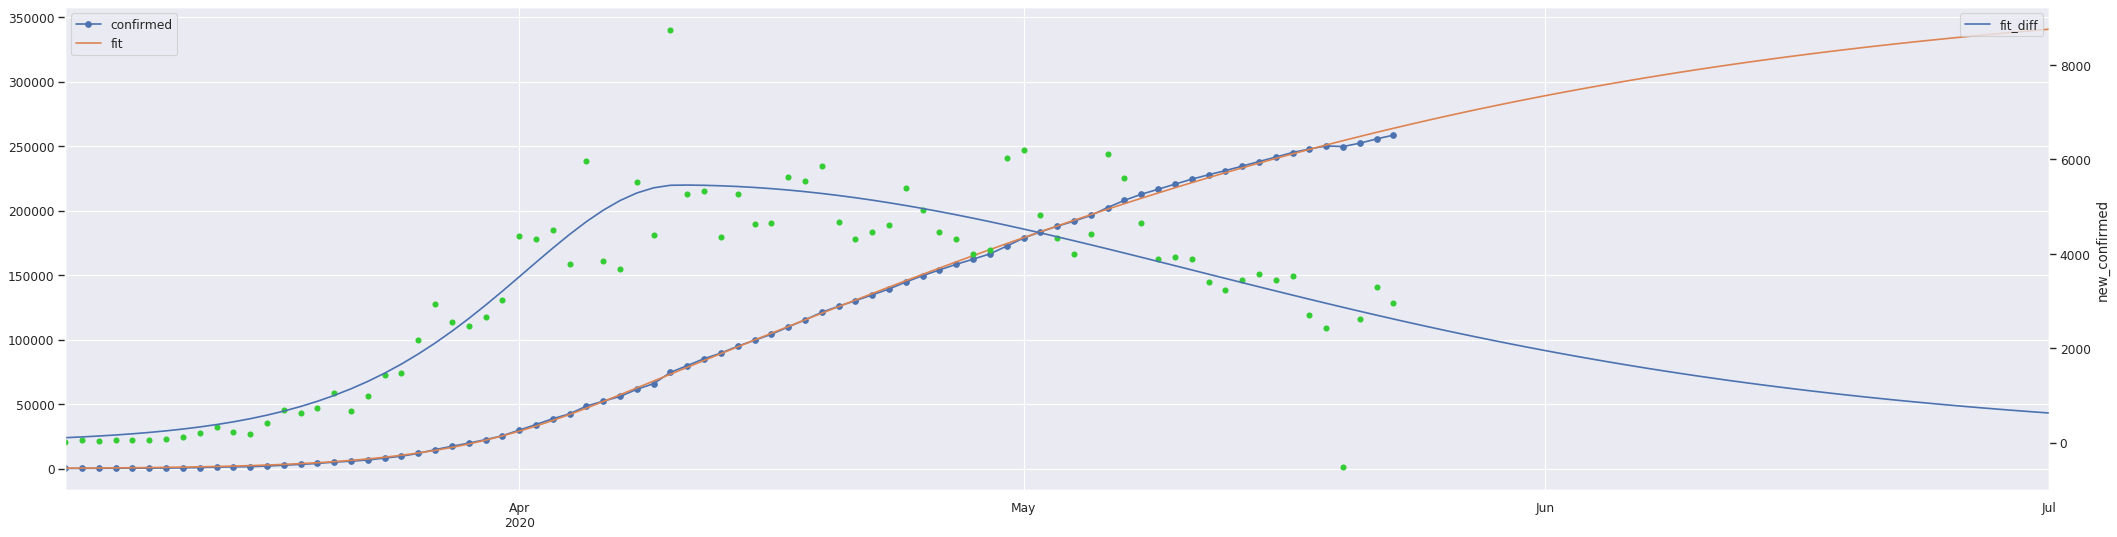

In [56]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_uk.plot_with_fits(ax=ax)

In [57]:
cbr_uk.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,5458.508318


In [58]:
cbr_uk.calculate_R_estimates()
cbr_uk.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-05-21,0.806,0.7,0.434,0.745,0.75


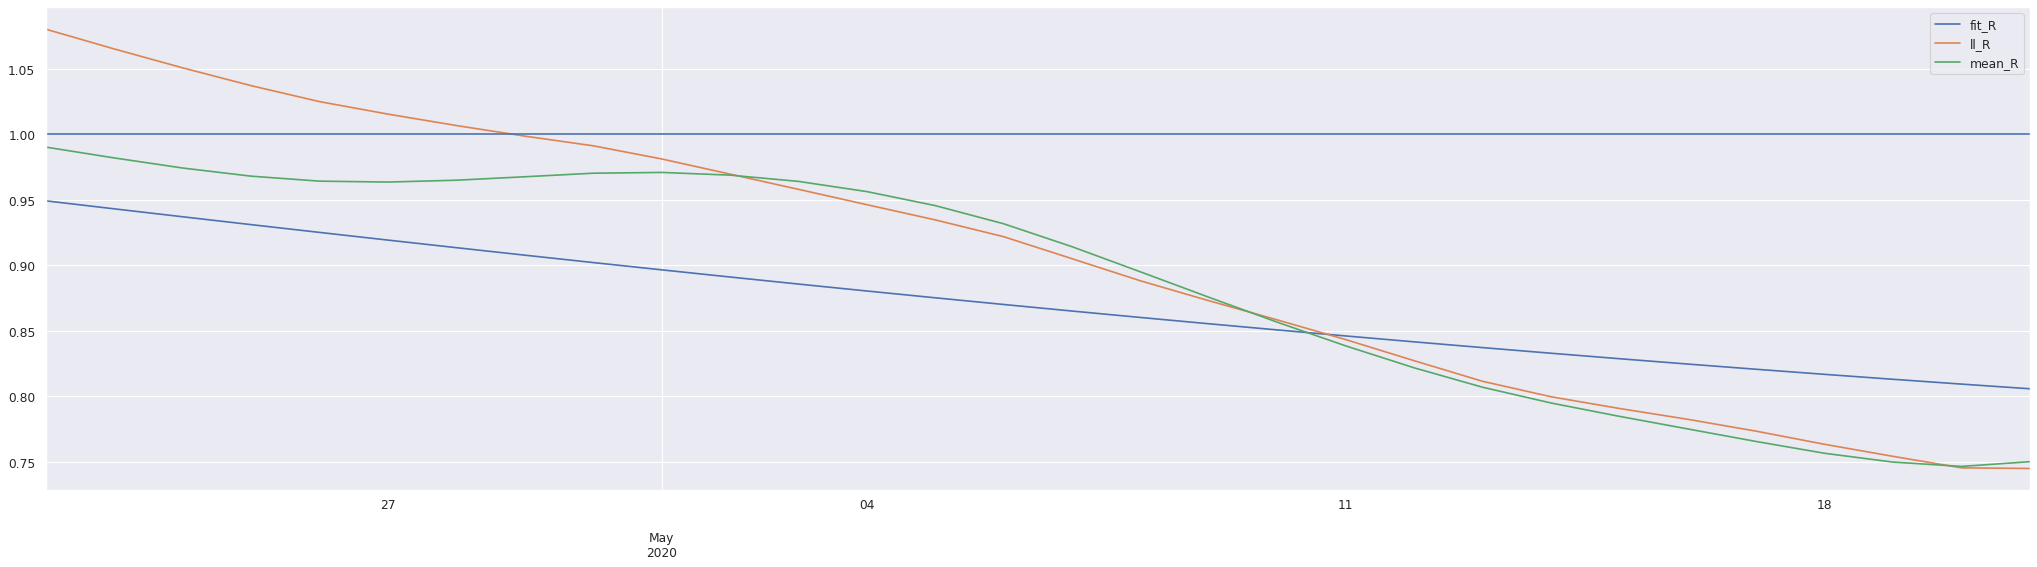

In [59]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_uk.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [60]:
cbr_us = covid19.CasesByRegion('US')
cbr_us.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-19,1528568,289392,91921,20260,6214,1574
2020-05-20,1551853,294312,93439,23285,4920,1518
2020-05-21,1577147,298418,94702,25294,4106,1263
2020-05-22,1600937,350135,95979,23790,51717,1277
2020-05-23,1622612,361239,97087,21675,11104,1108


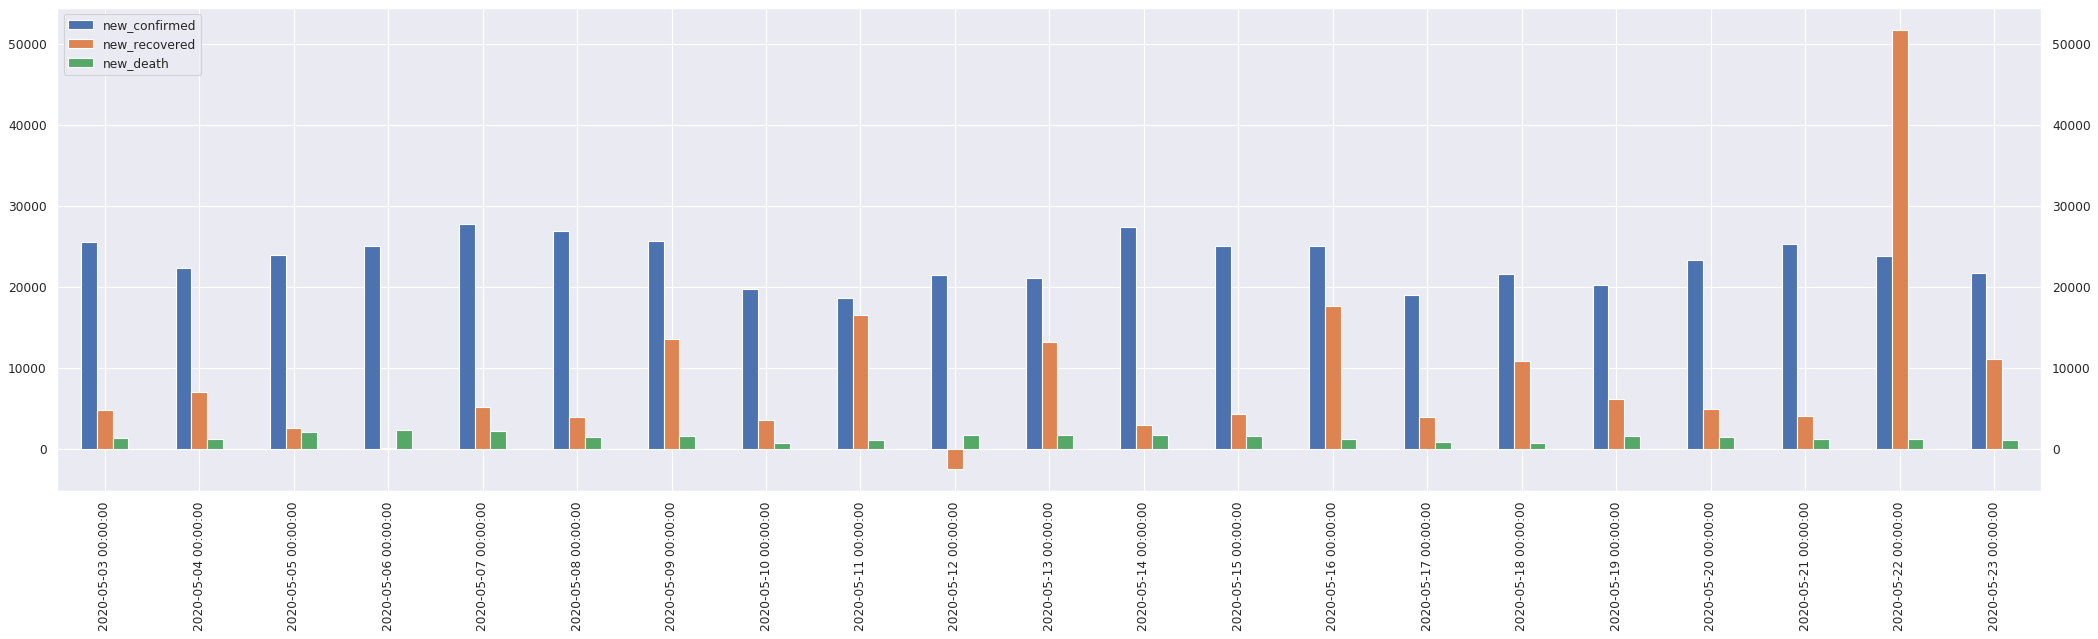

In [61]:
cbr_us.plot_daily_stats()

In [62]:
cbr_us.fit(first_date=pd.to_datetime('2020-03-11'))

sigmoid+asymmetric: seor: 2742.0257710933965, max asymptotic: 2545704.246989468; growth-rate: 0.013, date:2020-07-01 00:00:00, projected value: 9635.172013040645


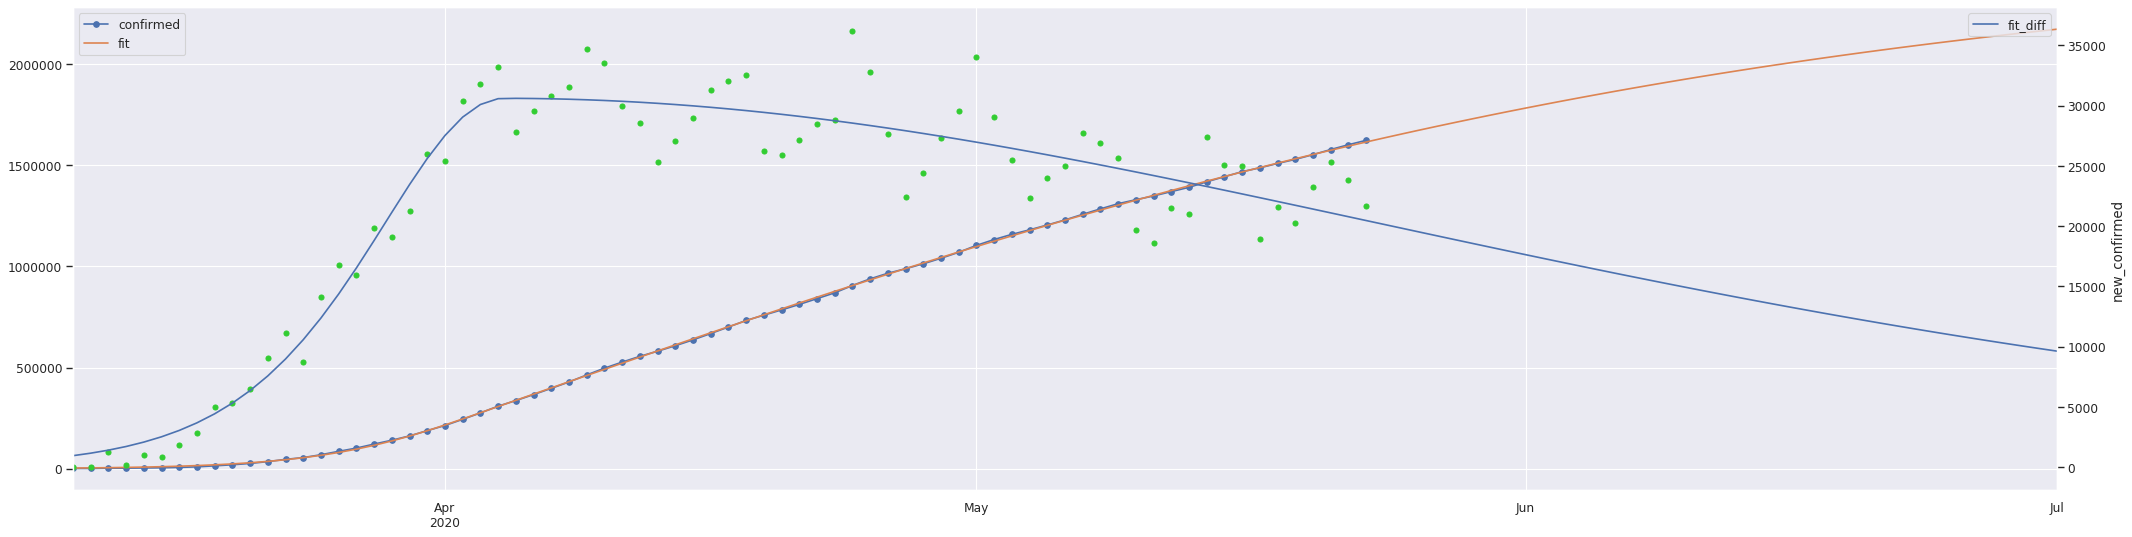

In [63]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_us.plot_with_fits(ax=ax)

In [64]:
cbr_us.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,30603.459542


In [65]:
cbr_us.calculate_R_estimates()
cbr_us.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-05-21,0.902,0.97,0.981,0.979,0.951


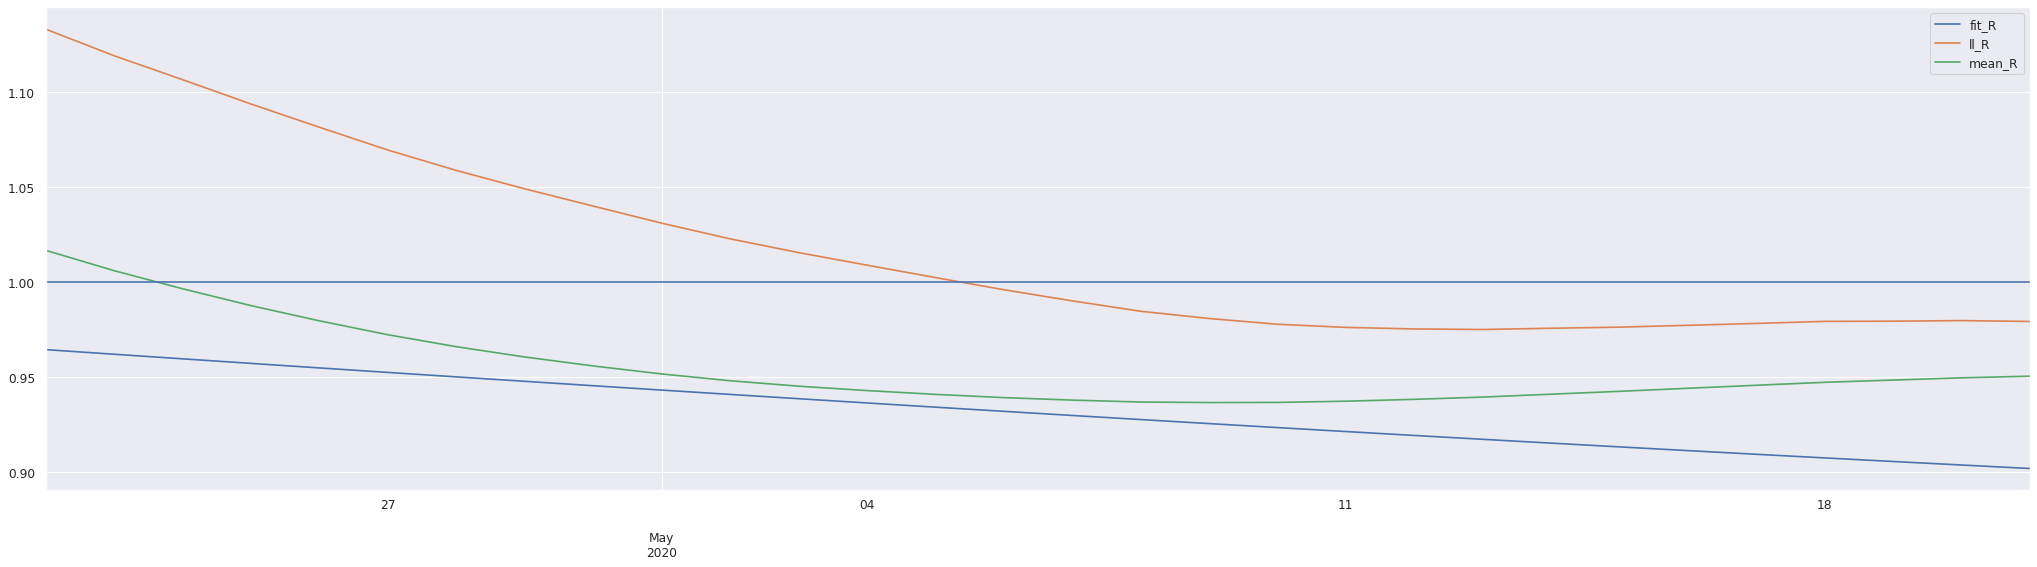

In [66]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_us.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [67]:
cbr_switzerland = covid19.CasesByRegion('Switzerland')
cbr_switzerland.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-19,30618,27700,1891,21,100,5
2020-05-20,30658,27800,1892,40,100,1
2020-05-21,30694,27900,1898,36,100,6
2020-05-22,30707,27900,1903,13,0,5
2020-05-23,30725,28000,1905,18,100,2


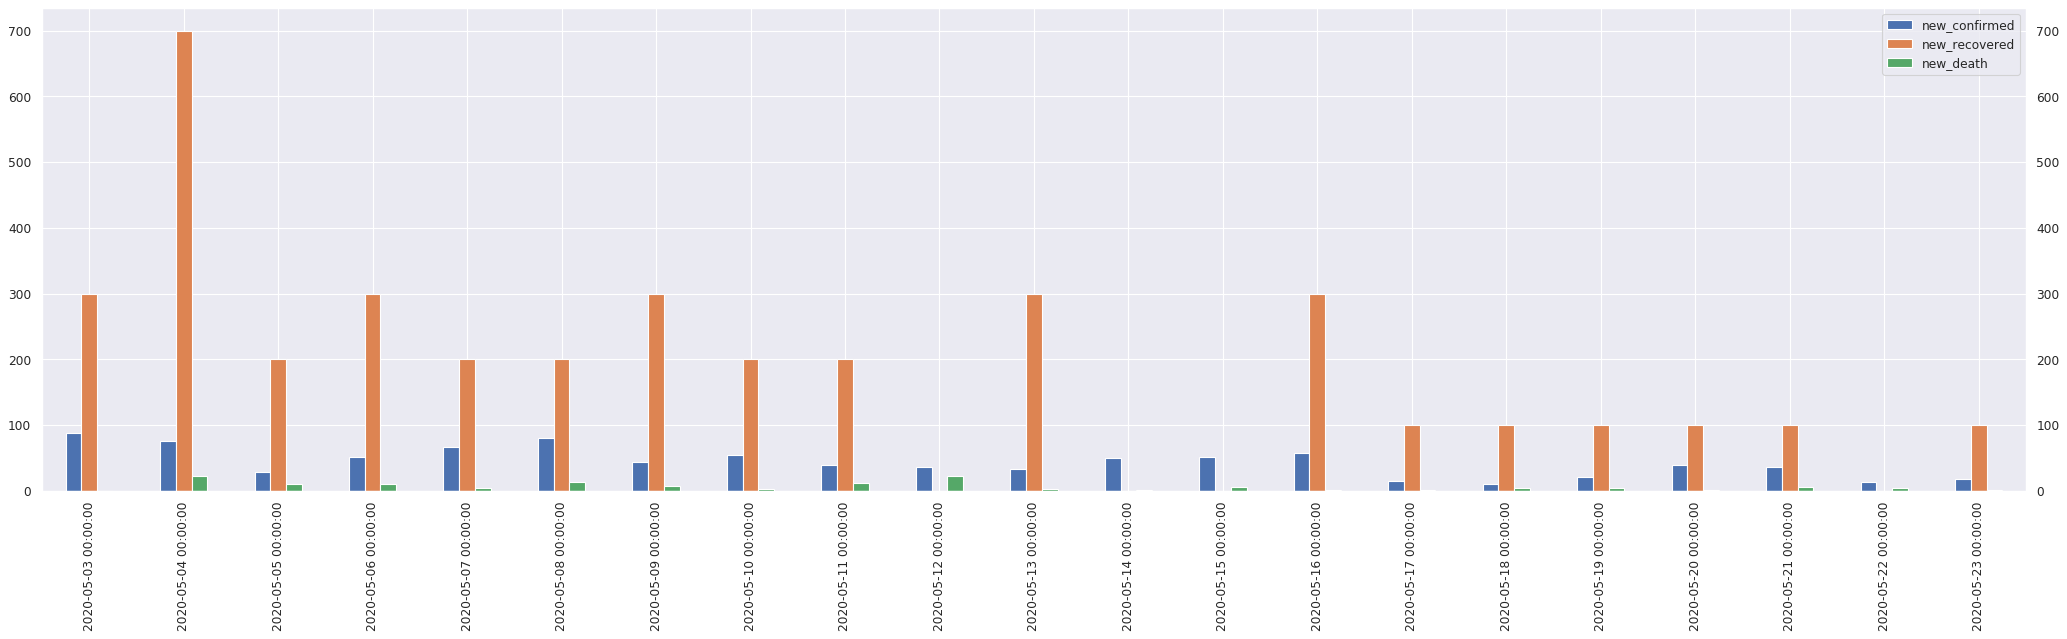

In [68]:
cbr_switzerland.plot_daily_stats()

In [69]:
cbr_switzerland.fit(first_date=pd.to_datetime('2020-03-05'), new_confirmed_threshold=1)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:Covariance of the parameters could not be estimated


sigmoid+asymmetric: seor: 145.63773657767896, max asymptotic: 30706.455267571935; growth-rate: 0.0, date:2020-06-21 00:00:00, projected value: 0.8966431497286199


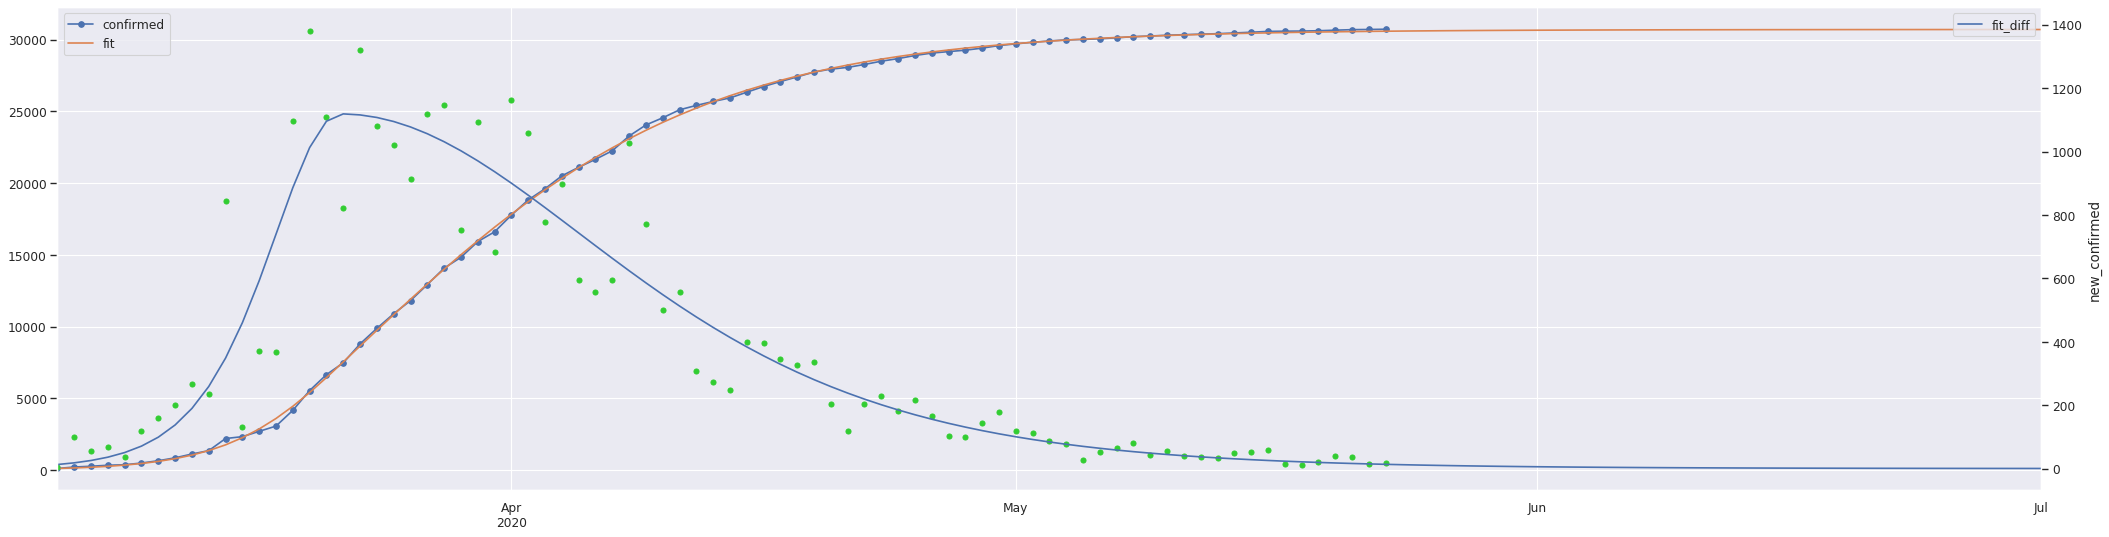

In [70]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_switzerland.plot_with_fits(ax=ax)

In [71]:
cbr_switzerland.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,1118.626216


In [72]:
cbr_switzerland.calculate_R_estimates()
cbr_switzerland.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-05-21,0.382,0.707,0.752,0.622,0.57


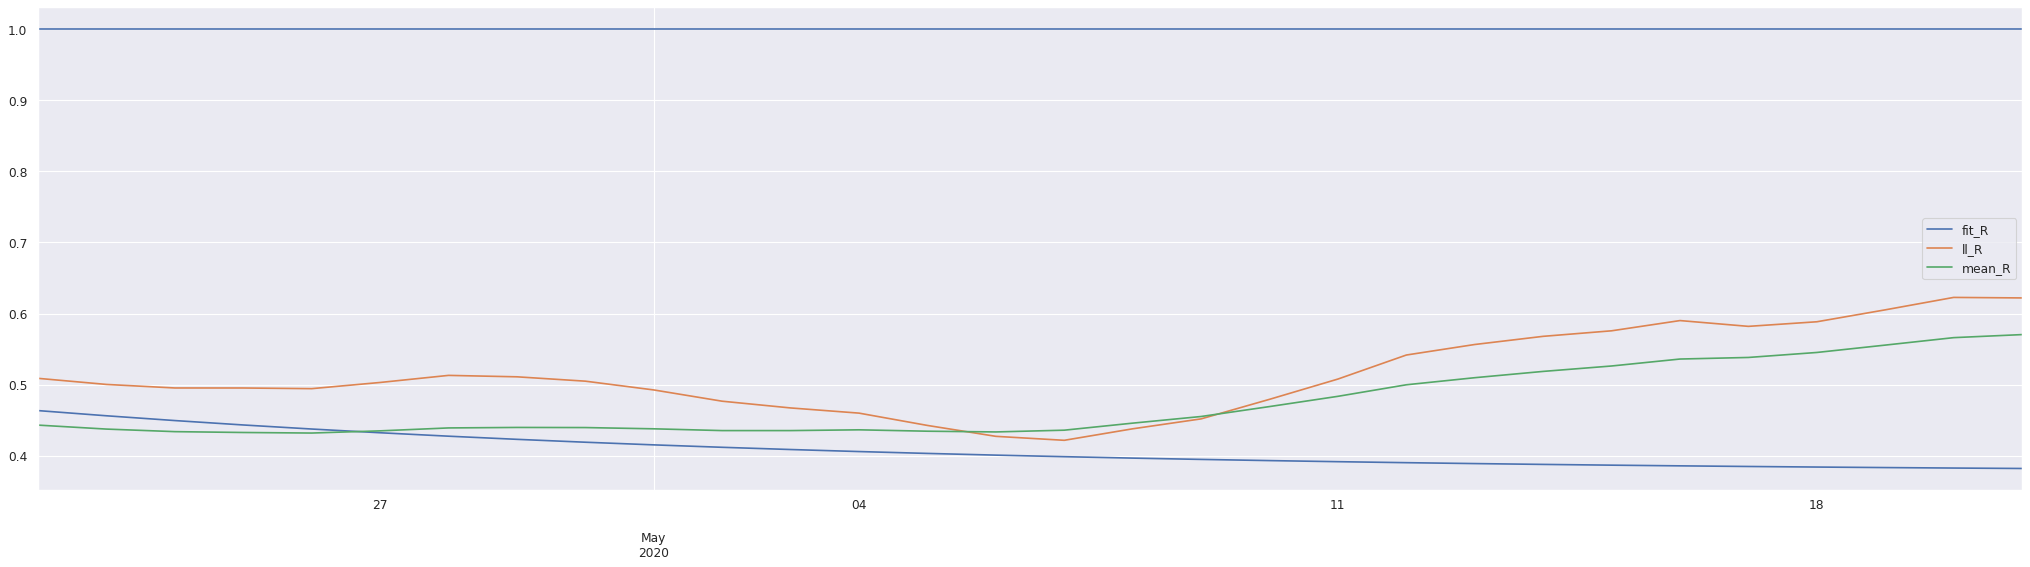

In [73]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_switzerland.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [74]:
cbr_australia = covid19.CasesByRegion('Australia')
cbr_australia.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-19,7072,6431,100,4,18,1
2020-05-20,7081,6470,100,9,39,0
2020-05-21,7095,6478,101,14,8,1
2020-05-22,7099,6485,101,4,7,0
2020-05-23,7114,6508,102,15,23,1


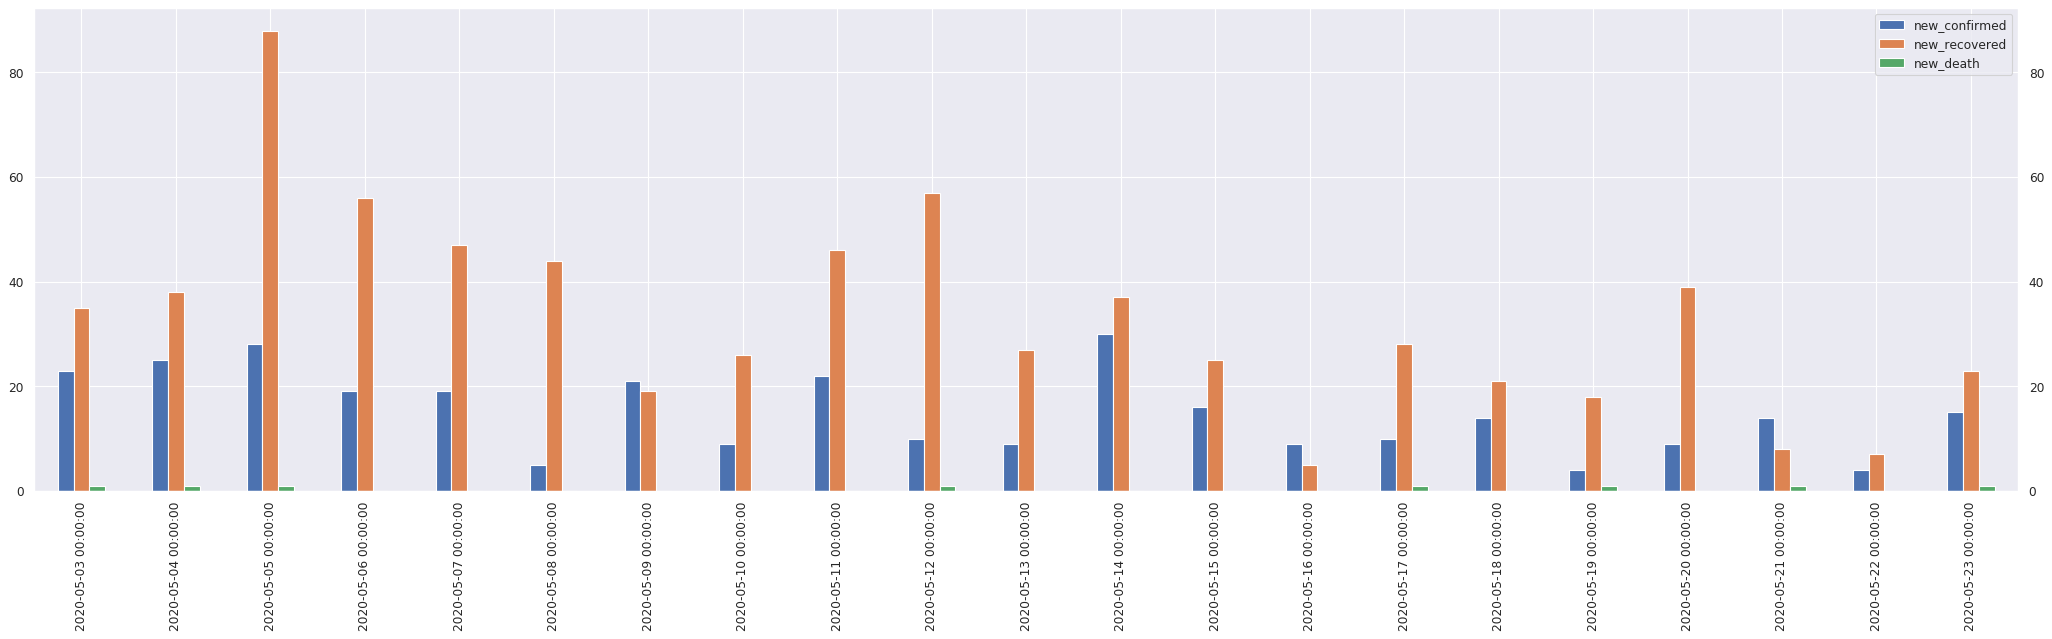

In [75]:
cbr_australia.plot_daily_stats()

In [76]:
cbr_australia.fit(first_date=pd.to_datetime('2020-03-10'), new_confirmed_threshold=2.0)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 44.94513634398506; growth-rate: 0.002, date:2020-07-01 00:00:00, projected value: 16.458766784739677


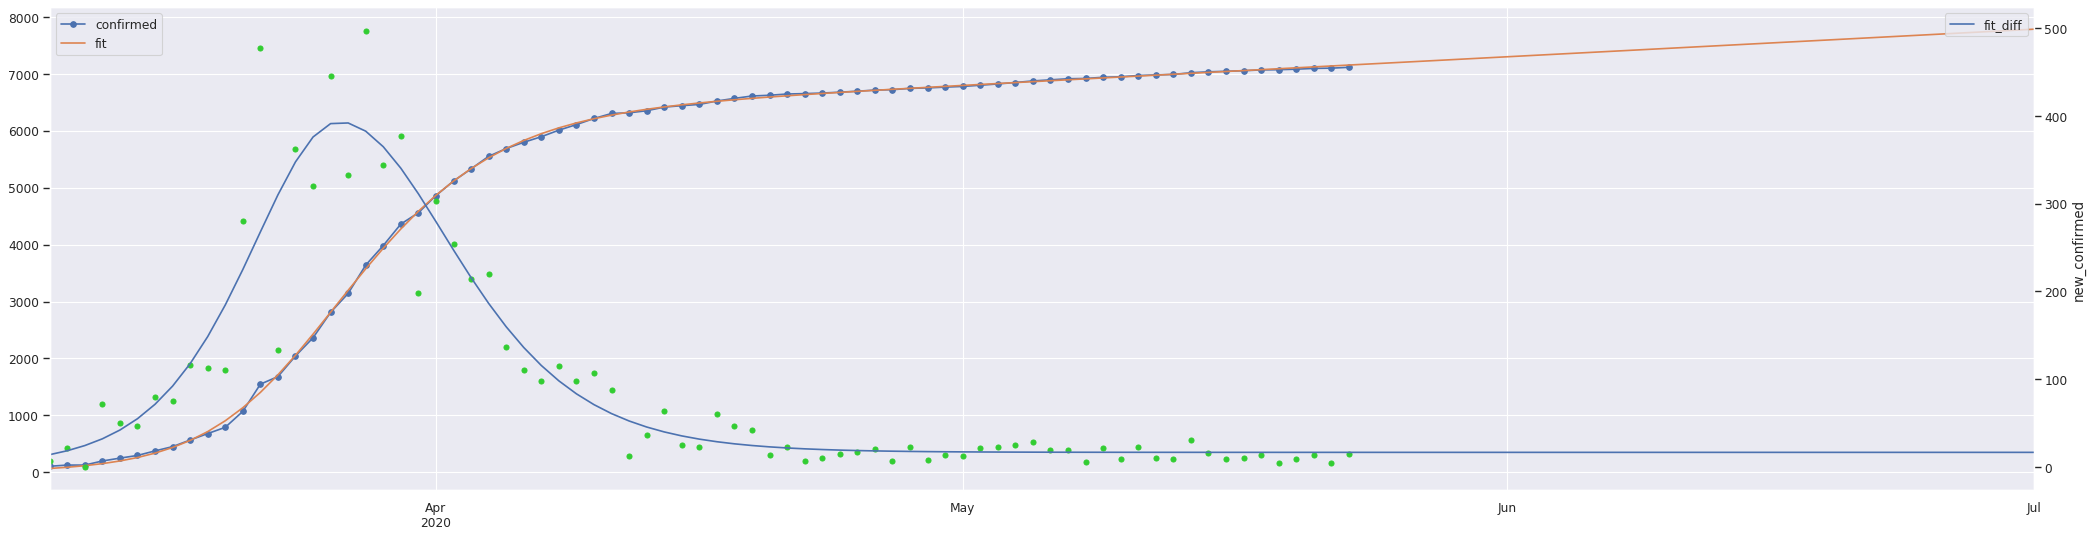

In [77]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_australia.plot_with_fits(ax=ax)

In [78]:
cbr_australia.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,392.022858


In [79]:
cbr_australia.calculate_R_estimates()
cbr_australia.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-05-21,0.999,0.602,0.081,0.525,0.709


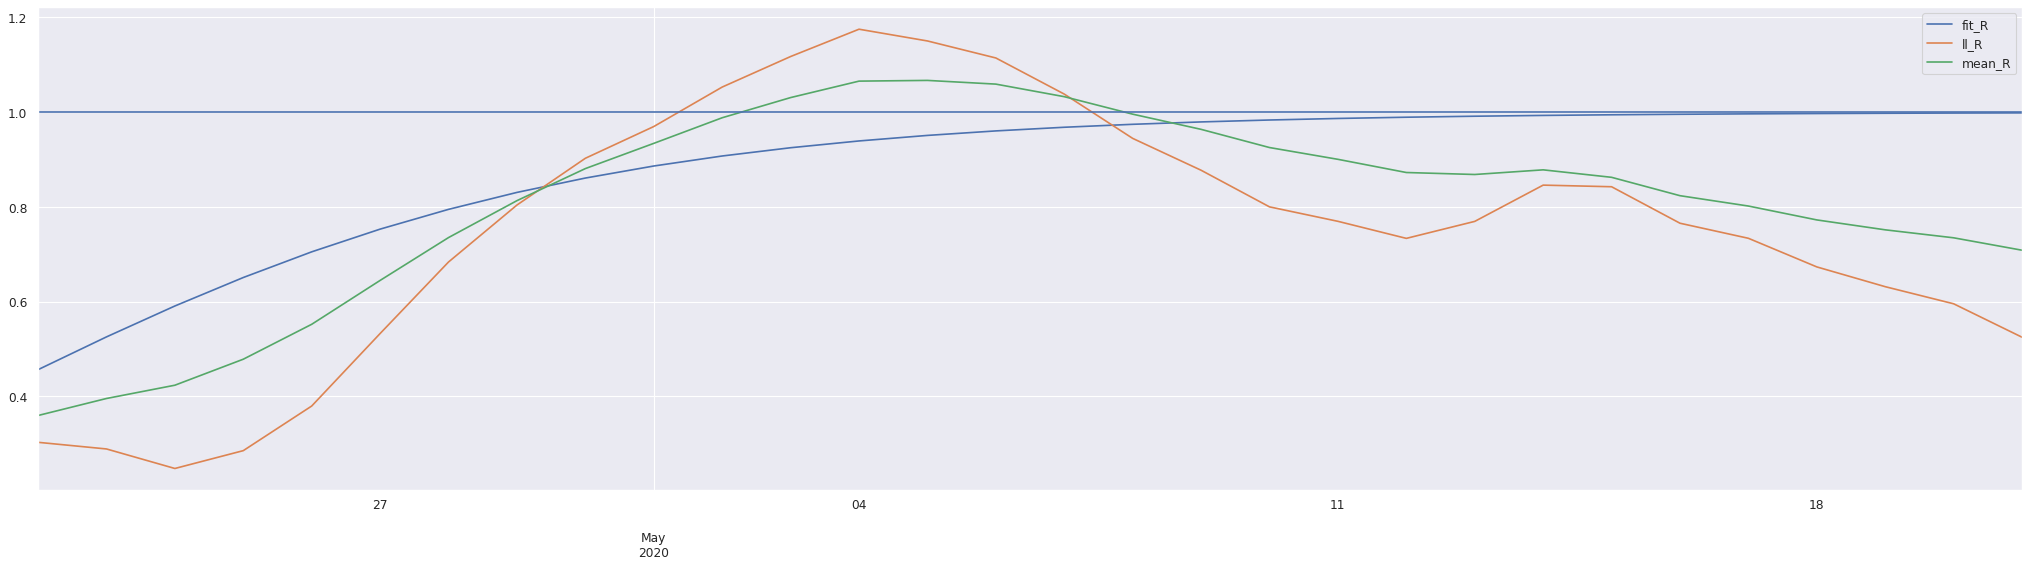

In [80]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_australia.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [81]:
df_co = covid19.get_country_overview()
df_co.head()

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-05-23,,,,,
MS Zaandam,9,0,2,22.222222,66.666667
Yemen,212,11,39,18.396226,76.470588
Belgium,56810,15155,9237,16.259461,37.867421
France,182036,63988,28218,15.501329,30.602883
Italy,229327,138840,32735,14.274377,19.079009


In [84]:
df_co[df_co.confirmed > 10000].round(1)

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-05-23,,,,,
Belgium,56810,15155,9237,16.3,37.9
France,182036,63988,28218,15.5,30.6
Italy,229327,138840,32735,14.3,19.1
United Kingdom,258504,1149,36757,14.2,97.0
Netherlands,45265,174,5830,12.9,97.1
Spain,235290,150376,28678,12.2,16.0
Sweden,33188,4971,3992,12.0,44.5
Mexico,65856,44424,7179,10.9,13.9
Ecuador,36258,3557,3096,8.5,46.5
